In [7]:
#import sys
#sys.path.append(r"D:\Python3.9\my_script\main.py")

#print(os.getcwd())
print(pd.__version__)

NameError: name 'pd' is not defined

In [2]:
import numpy as np
import pandas as pd
import math 
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
print(os.getcwd())
from scipy import stats
from scipy.stats import chi2_contingency #卡方檢定 & Crames'v
import statistics
from IPython.display import display  #在jupyter notebook 使用預覽畫面
import sklearn
print(sklearn.__version__)
#如果只有 0.19 記得要更新至 最新版本
%matplotlib inline
# 特徵選取會用到的函數
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

import pingouin as pg  # ANOVA 單因子及變數顯著性分析 (https://pingouin-stats.org/build/html/index.html)
import researchpy      #Cramér's V（克拉梅V係數）
plt.rcParams['font.family'] = 'Microsoft JhengHei' #顯示中文字(Windows)
#plt.rcParams['font.family'] = 'Heiti TC' #顯示中文字(Mac OS)


D:\Python3.9
1.5.1


# <font color ='red'>**壹、匯入檔案資料**</font>

In [6]:
final_datav3 = pd.read_excel('/Users/sky/Documents/公司資料/高雄銀行/每月分析報告/202508/rawdata/final_datav3.xlsx',dtype = {'消費序號':str,'帳單月份_WBBL':str,'信用卡號':str,'卡片狀態':str},skipfooter = 1)
#final_datav3 = pd.read_excel(r'D:\數據分析科\每月分析報告\202508\rawdata\final_datav3.xlsx',dtype = {'消費序號':str,'帳單月份_WBBL':str,'信用卡號':str,'卡片狀態':str},skipfooter = 1)

# <font color ='red'>**貳、資料探勘**</font>

In [41]:
#消費產品地點名稱各項數據
foreign_data = final_datav3[final_datav3['國內外結帳地點']!='國內'].groupby(['消費產品地點名稱']).agg({'客戶數':'count','卡片額度':'mean','消費筆數':'sum','台幣消費金額_WBBL':'sum','手續費收入':'sum','貢獻度':'sum'}).\
    sort_values(['消費筆數','台幣消費金額_WBBL','手續費收入','貢獻度'],ascending = [False,True,False,False]).apply(lambda x: x.map(lambda x: f'{x:,.0f}')).reset_index()
foreign_data.to_excel('/Users/sky/Documents/公司資料/高雄銀行/每月分析報告/202508/rawdata/foreign_data.xlsx',index = False)

In [17]:
'''
檢視伊朗刷卡明細 (主要應為企業戶購買材料，或當地旅遊刷卡為主)
'''
Iran = final_datav3[(final_datav3['消費產品地點名稱']=='伊朗')&(final_datav3['國內外結帳地點']!='國內')].groupby(['消費說明_WBBL','客戶歸屬分行名稱','Gender','年齡','幣別']).\
    agg({'客戶數':'count','卡片額度':'mean','台幣消費金額_WBBL':'sum','手續費收入':'sum','貢獻度':'sum'}).\
    sort_values(['台幣消費金額_WBBL','貢獻度'],ascending = [True,False]).apply(lambda x: x.map(lambda x: f'{x:,.0f}')).reset_index()
#Iran.to_excel('Iran.xlsx',index = False)

#因使用apply()後，數字將 轉成object格式，故轉回float or int,並且拿掉千分位 ','
Iran[['客戶數','卡片額度','台幣消費金額_WBBL','手續費收入','貢獻度']] = Iran[['客戶數','卡片額度','台幣消費金額_WBBL','手續費收入','貢獻度']].\
    replace(',','',regex = True).astype(int)

Iran_data = Iran.groupby(['消費說明_WBBL','幣別']).agg({'客戶數':'sum','卡片額度':'mean','台幣消費金額_WBBL':'sum','手續費收入':'sum','貢獻度':'sum'})\
    .sort_values(['台幣消費金額_WBBL','貢獻度'],ascending = [True,False]).apply(lambda x: x.map(lambda x: f'{x:,.0f}')).reset_index()
Iran_data

,消費說明_WBBL,幣別,客戶數,卡片額度,台幣消費金額_WBBL,手續費收入,貢獻度
0,TOYOKO INN 063 HP BOOK,JPY,1,"250,000","1,892",0,234
1,TOYOKO INN 038 HP BOOK,JPY,1,"250,000","2,234",0,234
2,TOYOKO INN 036 HP BOOK,JPY,1,"250,000","2,556",0,234
3,AVIRA,USD,1,"300,000","2,751",0,"54,752"


In [28]:
#信用卡風險等級註記個項數據
final_datav3.groupby(['信用卡類別']).agg({'客戶數':'count','卡片額度':'mean','消費筆數':'sum','台幣消費金額_WBBL':'sum','手續費收入':'sum','貢獻度':'sum'}).\
    sort_values(['消費筆數','台幣消費金額_WBBL','貢獻度'],ascending = [False,False,False]).apply(lambda x: x.map(lambda x: f'{x:,.0f}')).reset_index()

,信用卡類別,客戶數,卡片額度,消費筆數,台幣消費金額_WBBL,手續費收入,貢獻度
0,高雄ｇｏｉｎｇ鈦金卡_一般卡,"45,168","196,562","606,087","98,726,441","1,988,254","324,975,422"
1,一般金卡,"41,050","113,578","491,881","58,410,056","8,978,897","111,585,785"
2,高雄ｇｏｉｎｇ鈦金卡_行員卡,"24,078","135,768","251,263","45,668,507","22,045,785","34,440,980"
3,高雄市政府認同卡,"3,214","156,437","16,258","6,878,296","2,350","3,663,301"
4,M-普(認)卡轉換V-金卡,"2,689","107,668","12,893","3,037,392",0,"3,419,592"
5,M-福慧卡轉換V-金卡,"1,337","142,595","4,744","2,393,784","35,900","3,421,957"
6,高雄市政府-採購卡(V),43,"701,163",941,"65,076",0,"58,869"


    幣別    交易總數         平均   中位數   平均/中位數比   前10%貢獻率
5  TWD  123299  12.460738   6.0  2.076790  0.432193
6  USD   17821  13.349064  14.0  0.953505  0.296560
2  EUR    4036  26.906667  14.0  1.921905  0.237859
3  HUF      98  14.000000  14.0  1.000000  0.142857
0  CHF      93   8.454545  11.0  0.768595  0.139785
4  SGD     203   7.518519  11.0  0.683502  0.137931
1  CZK     689  24.607143  25.0  0.984286  0.116110


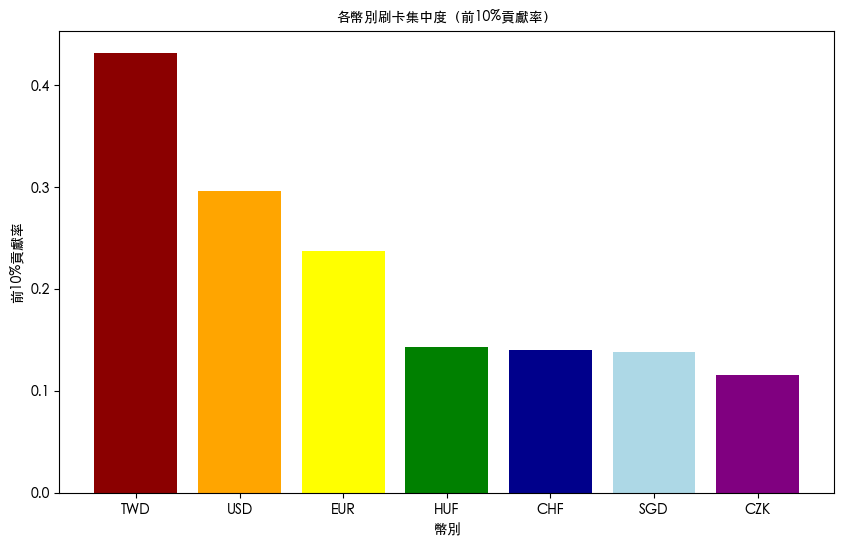

In [306]:
#final_datav3_curr.groupby("幣別")["刷卡筆數"].apply(lambda x: x.sort_values(ascending=False).head(int(0.1*len(x))).sum() / x.sum())


# 定義函式：計算集中度
def 刷卡集中度(df, 群組欄="幣別", 數值欄="刷卡筆數", 前比例=0.1):
    結果 = []
    
    for 名稱, 子集 in df.groupby(群組欄):
        總數 = 子集[數值欄].sum()
        平均 = 子集[數值欄].mean()
        中位數 = 子集[數值欄].median()
        
        # 前比例（例如前10%）客戶的貢獻率
        n_top = max(1, int(len(子集) * 前比例))
        前幾名總和 = 子集[數值欄].sort_values(ascending=False).head(n_top).sum()
        前幾名比例 = 前幾名總和 / 總數 if 總數 > 0 else 0
        
        結果.append({
            群組欄: 名稱,
            "交易總數": 總數,
            "平均": 平均,
            "中位數": 中位數,
            "平均/中位數比": 平均 / 中位數 if 中位數 > 0 else None,
            f"前{int(前比例*100)}%貢獻率": 前幾名比例
        })
    
    return pd.DataFrame(結果).sort_values(by="前10%貢獻率", ascending=False)


# === 使用範例 ===
summary = 刷卡集中度(final_datav3_curr, 群組欄="幣別", 數值欄="刷卡筆數", 前比例=0.1)
print(summary)

# 畫圖：前10%貢獻率
plt.figure(figsize=(10,6))
plt.bar(summary["幣別"], summary["前10%貢獻率"], 
        color=["darkred",'orange','yellow', 'green','darkblue','lightblue','purple'])
plt.ylabel("前10%貢獻率", fontproperties="Heiti TC")
plt.xlabel("幣別", fontproperties="Heiti TC")
plt.title("各幣別刷卡集中度（前10%貢獻率）", fontproperties="Heiti TC")
#plt.xticks(rotation=45, fontproperties="Heiti TC")
plt.yticks(fontproperties="Heiti TC")
plt.savefig("幣別貢獻度與集中度關係.png",bbox_inches = 'tight')
plt.show()


# <font color ='red'>**參、類別變數關係**</font>

### <font color ='skyblue'>**參-1、類別變數關係**</font>

In [133]:
print(final_datav3.shape)
final_datav3.info()

(117579, 49)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117579 entries, 0 to 117578
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   消費說明_WBBL           117577 non-null  object        
 1   消費日期_WBBL           117579 non-null  datetime64[ns]
 2   星期幾                 117579 non-null  object        
 3   消費序號                117579 non-null  object        
 4   帳單月份_WBBL           117579 non-null  object        
 5   信用卡號                117579 non-null  object        
 6   客戶編號                117579 non-null  object        
 7   年齡群組                117579 non-null  object        
 8   年齡                  117579 non-null  int64         
 9   Gender              117579 non-null  object        
 10  客戶歸屬分行名稱            117163 non-null  object        
 11  認列業績分行名稱            117579 non-null  object        
 12  消費產品地點名稱            117579 non-null  object        
 13  國內外結帳地點         

In [218]:
'''
排除離群值
'''
q_low = final_datav3['刷卡筆數'].quantile(q = 0.1)
q_high =final_datav3['刷卡筆數'].quantile(q = 0.9)
final_datav3_outlier = final_datav3[(final_datav3['刷卡筆數']>= q_low) & (final_datav3['刷卡筆數']<= q_high)]


In [305]:

def card_concentration(df, group_col="幣別", value_col="刷卡筆數", top_pct=0.1):
    results = []
    
    for name, group in df.groupby(group_col):
        total = group[value_col].sum()
        mean_val = group[value_col].mean()
        median_val = group[value_col].median()
        
        # 前 top_pct 比例客戶的貢獻率
        n_top = max(1, int(len(group) * top_pct))
        top_sum = group[value_col].sort_values(ascending=False).head(n_top).sum()
        top_ratio = top_sum / total if total > 0 else 0
        
        results.append({
            group_col: name,
            "交易總數": total,
            "平均": mean_val,
            "中位數": median_val,
            "平均/中位數比": mean_val / median_val if median_val > 0 else None,
            f"前{int(top_pct*100)}%貢獻率": top_ratio
        })
    
    return pd.DataFrame(results).sort_values(by="交易總數", ascending=False)

# 使用方式
summary = card_concentration(final_datav3_curr, group_col="幣別", value_col="刷卡筆數", top_pct=0.1)
#summary.to_excel('刷卡集中度.xlsx')
summary

,幣別,交易總數,平均,中位數,平均/中位數比,前10%貢獻率
5,TWD,123299,12.460738,6.0,2.076790,0.432193
6,USD,17821,13.349064,14.0,0.953505,0.296560
2,EUR,4036,26.906667,14.0,1.921905,0.237859
1,CZK,689,24.607143,25.0,0.984286,0.116110
4,SGD,203,7.518519,11.0,0.683502,0.137931
3,HUF,98,14.000000,14.0,1.000000,0.142857
0,CHF,93,8.454545,11.0,0.768595,0.139785


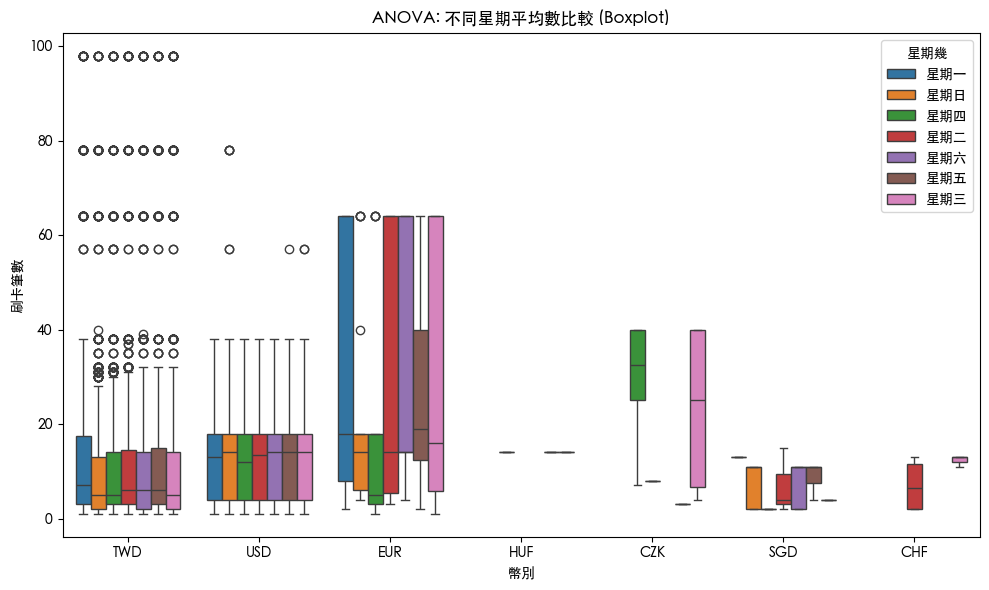

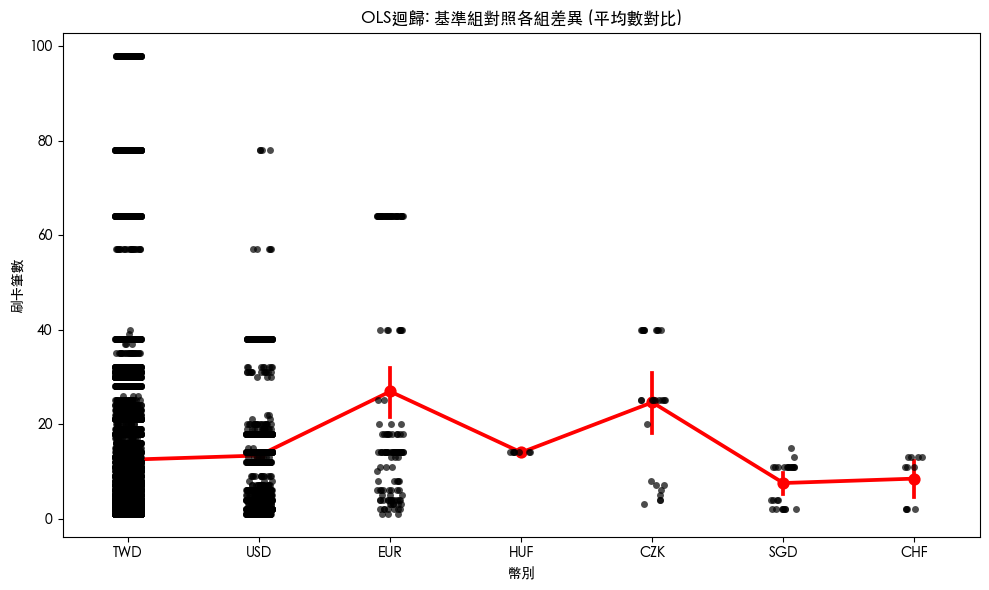

In [336]:
#plt.rcParams['font.family'] = 'Heiti TC'
# 畫 Boxplot 來對應 ANOVA
currency = ['TWD','CZK','HUF','USD','EUR','CHF','SGD']
final_datav3_curr = final_datav3[final_datav3['幣別'].isin(currency)]
plt.figure(figsize=(10,6))
sns.boxplot(x= '幣別', y="刷卡筆數", data = final_datav3_curr, hue = '星期幾')
 
plt.title("ANOVA: 不同星期平均數比較 (Boxplot)")
plt.xlabel("幣別")
#plt.xticks(rotation = 45)
plt.ylabel("刷卡筆數")
plt.tight_layout()
plt.savefig("交易筆數_currency.png",bbox_inches = 'tight')
plt.show()
# 畫 平均數 + 點圖 來對應 迴歸
plt.figure(figsize=(10,6))
sns.pointplot(x = '幣別', y = "刷卡筆數",data = final_datav3_curr, errorbar = ('ci', 99), color = "red")
sns.stripplot(x = '幣別', y = "刷卡筆數", data = final_datav3_curr, color="black", alpha=0.7, jitter=True)
plt.title("OLS迴歸: 基準組對照各組差異 (平均數對比)")
plt.xlabel("幣別")


plt.ylabel("刷卡筆數")
plt.tight_layout()
#plt.savefig("/mnt/data/regression_means.png")
plt.show()

### <font color ='skyblue'>**參-2、連續變數關係**</font>

In [849]:
corr_seqdata = final_datav3_2.loc[:,~final_datav3_2.columns.str.contains('客戶數|卡片張數|外幣消費金額|刷卡筆數|卡片狀態|信用卡號|消費序號')].\
    corr(method='spearman',numeric_only = True)

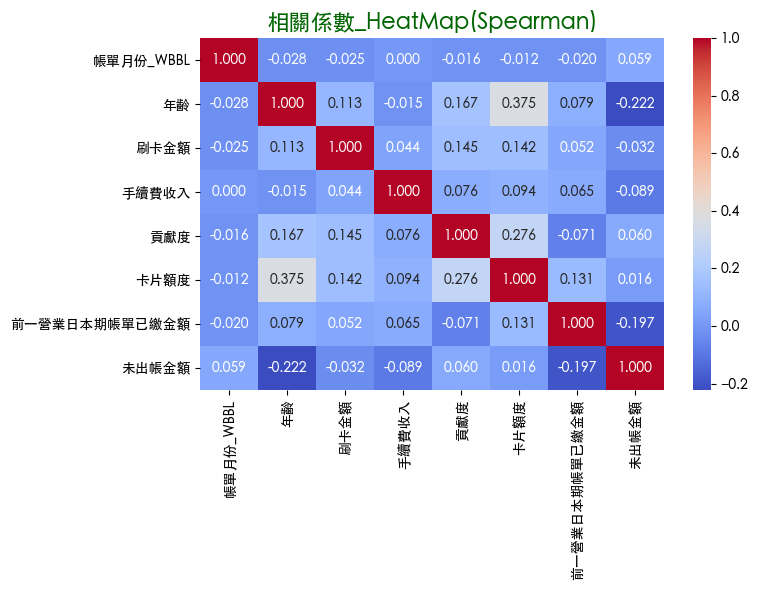

In [854]:
# 熱力圖

plt.figure(figsize=(8,6))
sns.heatmap(data = corr_seqdata, annot = True, fmt = ".3f", cmap = "coolwarm")
plt.title("相關係數_HeatMap(Spearman)",fontdict = {'fontsize':'16', 'fontweight':'bold','color':'darkgreen'})
plt.xticks(rotation = 90)
plt.tight_layout()
#plt.savefig('相關係數_HeatMap(Spearman_nocreditcnt).png',bbox_inches='tight')
plt.show()

# <font color ='red'>**肆、特徵工程dummy、標準化、變數挑選**</font>

### <font>**肆-1、卡方檢定(Cramer's V)和ANOVA單因子檢定**</font>

In [335]:
table = pd.crosstab(final_datav3['客戶歸屬分行名稱'], final_datav3['年齡群組'])
chi2, p, dof, expected = chi2_contingency(table)

#table.dtypes
#print(table)
print(f"卡方值: {chi2:.3f}")
print(f"p-value: {p:.20f}")
print(f'自由度:{dof}')
#print(f'理論期望出現次數:{expected}')

卡方值: 75563.019
p-value: 0.00000000000000000000
自由度:280


In [330]:

def CramerV(df, x, y):
    confusion_matrix = pd.crosstab(df[x],df[y])
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

#建立空矩陣
df = pd.DataFrame(
    np.zeros((len(binary_cols), len(binary_cols))),
    columns = binary_cols,
    index = binary_cols
)
    
for x in binary_cols:
    for y in binary_cols:
        value = CramerV(final_datav3,x,y)
        df.loc[x, y] = value
df

,客戶歸屬分行名稱,認列業績分行名稱,消費產品地點名稱,幣別,年齡群組,信用卡類別,個人評等,客戶風險等級,信用卡等級,國內外結帳地點,開卡狀態,Gender,星期幾
客戶歸屬分行名稱,1.000000,0.703796,0.172741,0.218913,0.283932,0.286598,0.224217,0.330596,0.266822,0.161357,0.189514,0.352809,0.031448
認列業績分行名稱,0.703796,1.000000,0.169813,0.218514,0.288230,0.277283,0.207134,0.323538,0.280330,0.188077,0.204679,0.306778,0.033890
消費產品地點名稱,0.172741,0.169813,1.000000,0.229919,0.148513,0.108680,0.054924,0.127490,0.141602,0.041238,0.016948,0.154082,0.019753
幣別,0.218913,0.218514,0.229919,1.000000,0.255749,0.156979,0.102789,0.202380,0.152935,0.998841,0.039104,0.283369,0.073720
年齡群組,0.283932,0.288230,0.148513,0.255749,1.000000,0.184290,0.133525,0.220845,0.217717,0.274468,0.055470,0.072251,0.018798
信用卡類別,0.286598,0.277283,0.108680,0.156979,0.184290,1.000000,0.186613,0.435799,0.909799,0.057022,0.043640,0.092754,0.017298
個人評等,0.224217,0.207134,0.054924,0.102789,0.133525,0.186613,1.000000,0.280729,0.169683,0.029945,0.020743,0.103112,0.015622
客戶風險等級,0.330596,0.323538,0.127490,0.202380,0.220845,0.435799,0.280729,1.000000,0.276318,0.038557,0.043172,0.141617,0.014902
信用卡等級,0.266822,0.280330,0.141602,0.152935,0.217717,0.909799,0.169683,0.276318,1.000000,0.020841,0.039695,0.019268,0.018115
國內外結帳地點,0.161357,0.188077,0.041238,0.998841,0.274468,0.057022,0.029945,0.038557,0.020841,0.999841,0.011523,0.026781,0.010305


In [331]:
from typing import Literal
# 計算單一對欄位的 Cramér's V
def cramers_v(df: pd.DataFrame, col1: str, col2: str) -> float:
    confusion_matrix = pd.crosstab(df[col1], df[col2])
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.to_numpy().sum()
    r, k = confusion_matrix.shape
    phi2 = chi2 / n
    return np.sqrt(phi2 / min(r - 1, k - 1))

# 判斷強度 (依自由度 df_degree + 數值 v)
def judgment_cramerv(
    df_degree: int, 
    v: float
) -> Literal['Negligible','Small','Medium','Large']:
    if df_degree == 1:
        if v < 0.1: return 'Negligible'
        elif v < 0.3: return 'Small'
        elif v < 0.5: return 'Medium'
        else: return 'Large'
    elif df_degree == 2:
        if v < 0.07: return 'Negligible'
        elif v < 0.21: return 'Small'
        elif v < 0.35: return 'Medium'
        else: return 'Large'
    elif df_degree == 3:
        if v < 0.06: return 'Negligible'
        elif v < 0.17: return 'Small'
        elif v < 0.29: return 'Medium'
        else: return 'Large'
    elif df_degree == 4:
        if v < 0.05: return 'Negligible'
        elif v < 0.15: return 'Small'
        elif v < 0.25: return 'Medium'
        else: return 'Large'
    else:
        if v < 0.05: return 'Negligible'
        elif v < 0.13: return 'Small'
        elif v < 0.22: return 'Medium'
        else: return 'Large'

# 建立分類矩陣
def cramers_v_matrix(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    res = pd.DataFrame(index=cols, columns=cols, dtype=object)
    for c1 in cols:
        for c2 in cols:
            if c1 == c2:   # 對角線 → 不計算
                res.loc[c1, c2] = np.nan
            else:
                v = cramers_v(df, c1, c2)
                r, k = pd.crosstab(df[c1], df[c2]).shape
                df_degree = min(r - 1, k - 1)
                res.loc[c1, c2] = judgment_cramerv(df_degree, v)
    return res
binary_cols = ['客戶歸屬分行名稱', '認列業績分行名稱', '消費產品地點名稱', '幣別', '年齡群組','信用卡類別','個人評等','客戶風險等級','信用卡等級','國內外結帳地點'
              ,'開卡狀態','Gender','星期幾']
result = cramers_v_matrix(final_datav3, binary_cols)
#result.to_excel('顯著類別變數關係.xlsx')
result

,客戶歸屬分行名稱,認列業績分行名稱,消費產品地點名稱,幣別,年齡群組,信用卡類別,個人評等,客戶風險等級,信用卡等級,國內外結帳地點,開卡狀態,Gender,星期幾
客戶歸屬分行名稱,NaN,Large,Medium,Medium,Large,Large,Large,Medium,Medium,Small,Small,Medium,Negligible
認列業績分行名稱,Large,NaN,Medium,Medium,Large,Large,Medium,Medium,Medium,Small,Small,Medium,Negligible
消費產品地點名稱,Medium,Medium,NaN,Large,Medium,Small,Small,Small,Small,Negligible,Negligible,Small,Negligible
幣別,Medium,Medium,Large,NaN,Large,Medium,Small,Small,Small,Large,Negligible,Small,Small
年齡群組,Large,Large,Medium,Large,NaN,Medium,Medium,Medium,Medium,Small,Negligible,Negligible,Negligible
信用卡類別,Large,Large,Small,Medium,Medium,NaN,Medium,Large,Large,Negligible,Negligible,Negligible,Negligible
個人評等,Large,Medium,Small,Small,Medium,Medium,NaN,Medium,Small,Negligible,Negligible,Small,Negligible
客戶風險等級,Medium,Medium,Small,Small,Medium,Large,Medium,NaN,Medium,Negligible,Negligible,Small,Negligible
信用卡等級,Medium,Medium,Small,Small,Medium,Large,Small,Medium,NaN,Negligible,Negligible,Negligible,Negligible
國內外結帳地點,Small,Small,Negligible,Large,Small,Negligible,Negligible,Negligible,Negligible,NaN,Negligible,Negligible,Negligible


In [141]:
def judgment_etaSq(etaSq):
    if etaSq < .01:
        qual = 'Negligible'
    elif etaSq < .06:
        qual = 'Small'
    elif etaSq < .14:
        qual = 'Medium'
    else:
        qual = 'Large'
    return(qual)
judgment_etaSq(etaSq)

'Negligible'

In [329]:
# 使用 pingouin 套件 ANOVA單因子分析 (產出)
cat_cols = ['星期幾','客戶歸屬分行名稱','國內外結帳地點','消費產品地點名稱','認列業績分行名稱','Gender','年齡群組','開卡狀態','信用卡等級','信用卡類別','個人評等','客戶風險等級','幣別']
results = []
for i in cat_cols:
    aov = pg.anova(data = final_datav3, dv = '刷卡筆數', between = i, detailed=True)
    row = aov.loc[0,['Source','SS','DF','MS','F','p-unc','np2']]
    results.append(row)

aov_sort = pd.DataFrame(results)
                     
單因子顯著變數_ANOVA = aov_sort.sort_values(by = 'np2', ascending = False).reset_index(drop = True)
單因子顯著變數_ANOVA.to_excel('單因子顯著變數_ANOVA.xlsx')
單因子顯著變數_ANOVA

,Source,SS,DF,MS,F,p-unc,np2
0,客戶歸屬分行名稱,1.143611e+07,35,326745.943879,1583.688215,0.000000e+00,0.321224
1,認列業績分行名稱,1.004140e+07,34,295335.395108,1357.925817,0.000000e+00,0.282014
2,消費產品地點名稱,3.077886e+06,20,153894.294268,556.179600,0.000000e+00,0.086443
3,幣別,2.423580e+05,28,8655.643765,30.978871,5.768592e-159,0.062062
4,年齡群組,1.498802e+06,8,187350.303167,645.809085,0.000000e+00,0.042094
5,信用卡類別,5.378688e+05,6,89644.805583,300.549287,0.000000e+00,0.015106
6,個人評等,2.087346e+05,5,41746.912451,138.663304,3.755481e-147,0.005862
7,客戶風險等級,1.945614e+05,2,97280.715692,322.998989,1.280197e-140,0.005464
8,信用卡等級,1.556616e+05,2,77830.816793,258.014739,1.552315e-112,0.004373
9,國內外結帳地點,4.130694e+04,1,41306.936270,136.560656,1.566182e-31,0.001160


###    。以 ANOVA變異數 來觀察 **```客戶歸屬分行名稱```,```認列業績分行名稱```,```消費產品地點名稱```**，解釋力較佳 (>0.14)
###    <font color = skyblue>。SS為不同組平均數差異造成的變異、F越大組間差異越可能顯著、np2(effect size)越接近 1 → 變數解釋力越大。

In [262]:
final_datav3.groupby(['幣別']).agg({'刷卡筆數':'median','刷卡金額':'median'}).sort_values(['刷卡筆數','刷卡金額'], ascending = [False,False]).reset_index()
#final_datav3.describe() # 刷卡筆數(median = 5 ,mean =11)、刷卡金額(median = 500 ,mean =1830)
#CZK(25.0,830.5),HUF,(14.0,1227.0),USD(14,976),EUR(14.0,548.5),CHF(11.0,3812.0),SGD(11.0,641.0)

,幣別,刷卡筆數,刷卡金額
0,CZK,25.0,830.5
1,CNY,16.0,104.0
2,HUF,14.0,1227.0
3,USD,14.0,976.0
4,EUR,14.0,548.5
5,CHF,11.0,3812.0
6,SGD,11.0,641.0
7,CAD,10.0,238.0
8,GTQ,9.0,2615.0
9,JPY,7.0,913.0


### <font color ='skyblue'>**反應變數為類別與類別變數關係(僅測試category)**</font>

In [308]:
table = pd.crosstab(final_datav3['刷卡筆數'], final_datav3['消費'])
chi2, p, dof, expected = chi2_contingency(table)

#table.dtypes
#print(table)
print(f"卡方值: {chi2:.3f}")
print(f"p-value: {p:.20f}")
print(f'自由度:{dof}')
#print(f'理論期望出現次數:{expected}')

卡方值: 993.117
p-value: 0.00000000000000000000
自由度:264


In [127]:
import statsmodels.api as sm

In [372]:
for i, col in enumerate(X.columns):
    print(f'{i}:{col}')

0:const
1:星期幾_星期三
2:星期幾_星期二
3:星期幾_星期五
4:星期幾_星期六
5:星期幾_星期四
6:星期幾_星期日
7:客戶歸屬分行名稱_三民分行
8:客戶歸屬分行名稱_中和分行
9:客戶歸屬分行名稱_中壢分行
10:客戶歸屬分行名稱_九如分行
11:客戶歸屬分行名稱_前金分行
12:客戶歸屬分行名稱_北高雄分行
13:客戶歸屬分行名稱_南高雄分行
14:客戶歸屬分行名稱_博愛分行
15:客戶歸屬分行名稱_台中分行
16:客戶歸屬分行名稱_台北分行
17:客戶歸屬分行名稱_台南分行
18:客戶歸屬分行名稱_右昌分行
19:客戶歸屬分行名稱_大發分行
20:客戶歸屬分行名稱_大直分行
21:客戶歸屬分行名稱_大里分行
22:客戶歸屬分行名稱_小港分行
23:客戶歸屬分行名稱_屏東分行
24:客戶歸屬分行名稱_岡山本洲分行
25:客戶歸屬分行名稱_左營分行
26:客戶歸屬分行名稱_市府分行
27:客戶歸屬分行名稱_建國分行
28:客戶歸屬分行名稱_成大分行
29:客戶歸屬分行名稱_新竹分行
30:客戶歸屬分行名稱_新莊分行
31:客戶歸屬分行名稱_旗津簡易型分行
32:客戶歸屬分行名稱_板橋分行
33:客戶歸屬分行名稱_林口分行
34:客戶歸屬分行名稱_桂林分行
35:客戶歸屬分行名稱_桃園分行
36:客戶歸屬分行名稱_橋頭科學園區分行
37:客戶歸屬分行名稱_灣內分行
38:客戶歸屬分行名稱_營業部
39:客戶歸屬分行名稱_草衙分行
40:客戶歸屬分行名稱_鳳山分行
41:客戶歸屬分行名稱_鼓山分行
42:國內外結帳地點_國外
43:消費產品地點名稱_伊朗
44:消費產品地點名稱_克羅埃西亞
45:消費產品地點名稱_加拿大
46:消費產品地點名稱_台灣
47:消費產品地點名稱_塞普路斯
48:消費產品地點名稱_奧地利
49:消費產品地點名稱_德國
50:消費產品地點名稱_愛爾蘭
51:消費產品地點名稱_捷克
52:消費產品地點名稱_斯里蘭卡
53:消費產品地點名稱_新加坡
54:消費產品地點名稱_日本
55:消費產品地點名稱_法國
56:消費產品地點名稱_澳大利亞
57:消費產品地點名稱_瑞典
58:消費產品地點名稱_美國
59:消費產品地點名稱_義大利
60:消費產品地點名稱_英國
61:消費產品地點名稱_荷蘭
62:消費產品地點名稱_香港
63

In [375]:
print("X dtypes:\n", X.dtypes)
print("y dtype:\n", y.dtype)

X dtypes:
 const      float64
星期幾_星期三       bool
星期幾_星期二       bool
星期幾_星期五       bool
星期幾_星期六       bool
            ...   
幣別_THB        bool
幣別_TRY        bool
幣別_TWD        bool
幣別_USD        bool
幣別_VND        bool
Length: 151, dtype: object
y dtype:
 int64


In [383]:
X = final_datav3[['星期幾','客戶歸屬分行名稱','國內外結帳地點','消費產品地點名稱','認列業績分行名稱','Gender','年齡群組','開卡狀態','信用卡等級','信用卡類別','個人評等','客戶風險等級','幣別']]
X = pd.get_dummies(X, drop_first=True)   # 全部類別轉 dummy
X = X.apply(pd.to_numeric,errors = 'coerce')
y = final_datav3['刷卡筆數']
y = pd.to_numeric(y, errors = 'coerce')

df_clean = pd.concat([X, y], axis=1).dropna().astype(float)
X = df_clean.drop(columns=['刷卡筆數'])
y = df_clean['刷卡筆數']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit(cov_type = 'HC3')
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   刷卡筆數   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     597.4
Date:                Wed, 03 Sep 2025   Prob (F-statistic):               0.00
Time:                        15:22:54   Log-Likelihood:            -4.6937e+05
No. Observations:              117579   AIC:                         9.390e+05
Df Residuals:                  117428   BIC:                         9.405e+05
Df Model:                         150                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   34.1497 

In [1229]:
X = final_datav3_2[['客戶歸屬分行名稱','消費產品地點名稱','年齡群組','幣別']]
X = pd.get_dummies(X, drop_first=True)   # 全部類別轉 dummy
#X = X.apply(pd.to_numeric,errors = 'coerce')
y = final_datav3_2['刷卡筆數']
#y = pd.to_numeric(y, errors = 'coerce')

df_clean = pd.concat([X, y], axis=1).dropna().astype(float) # 左右合併資料
X = df_clean.drop(columns=['刷卡筆數'])                      # 去掉反應變數
y = df_clean['刷卡筆數']                             

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   刷卡筆數   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     1034.
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        00:10:37   Log-Likelihood:            -4.7386e+05
No. Observations:              117579   AIC:                         9.479e+05
Df Residuals:                  117506   BIC:                         9.486e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                33.5737      1.13

In [1227]:
import statsmodels.formula.api as smf
#df_clean.rename(columns = {'刷卡筆數':'creditcnt','sales_bch':'salesbch','belonged_bch':'belongedbch'},inplace = True)

model_interation = smf.ols('刷卡筆數 ~ 客戶歸屬分行名稱*認列業績分行名稱 + 消費產品地點名稱 + 年齡群組 + 幣別', data = final_datav3_2).fit()
print(model_interation.summary())

                            OLS Regression Results                            
Dep. Variable:                   刷卡筆數   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     324.6
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        00:09:11   Log-Likelihood:            -4.6271e+05
No. Observations:              117579   AIC:                         9.261e+05
Df Residuals:                  117226   BIC:                         9.295e+05
Df Model:                         352                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [407]:
resid

0         -4.240713
1        -30.859728
2         10.916027
3         -9.510633
4         12.524379
            ...    
117574   -20.881916
117575   -20.881916
117576     3.816393
117577    -6.090266
117578    -6.572017
Length: 117579, dtype: float64

# <font color ='jade'>**陸、連續變數檢查常態性 Shapiro-Wilk / KS test**</font>

In [493]:
final_datav3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117579 entries, 0 to 117578
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   消費說明_WBBL           117577 non-null  object        
 1   消費日期_WBBL           117579 non-null  datetime64[ns]
 2   星期幾                 117579 non-null  object        
 3   消費序號                117579 non-null  object        
 4   帳單月份_WBBL           117579 non-null  object        
 5   信用卡號                117579 non-null  object        
 6   客戶編號                117579 non-null  object        
 7   年齡群組                117579 non-null  object        
 8   年齡                  117579 non-null  int64         
 9   Gender              117579 non-null  object        
 10  客戶歸屬分行名稱            117163 non-null  object        
 11  認列業績分行名稱            117579 non-null  object        
 12  消費產品地點名稱            117579 non-null  object        
 13  國內外結帳地點             117579 no

In [498]:
#corr_seqdata = final_datav3.loc[:,~final_datav3.columns.str.contains('客戶數|卡片張數|外幣消費金額|刷卡筆數')].corr(method='spearman',numeric_only = True)
corr_seqdata.sort_values('刷卡金額', ascending = False)
corr_seqdata.to_excel('corr_contdata.xlsx')

In [447]:
y = final_datav3['刷卡筆數']
x = final_datav3[col].dropna()
x


0             0
1         17446
2             0
3          3079
4             0
          ...  
117574    13600
117575    13600
117576      785
117577     5774
117578     5774
Name: 未出帳金額, Length: 117579, dtype: int64

In [481]:
# 常態性shapiro, 關係係數(spearman, pearson)檢定

from scipy.stats import shapiro, spearmanr, pearsonr

y = final_datav3['刷卡筆數']  # 依變數
cont_cols = ['卡片額度', '年齡', '刷卡金額','手續費收入','貢獻度','前一營業日本期帳單已繳金額','未出帳金額']  # 連續變數清單

results = []
for col in cont_cols:
    x = final_datav3[col].dropna()
    n = len(x)
    # 常態性檢查
    if n > 5000:
        corr, pval = spearmanr(x, y.loc[x.index])
        method = 'Spearman'                          # 大樣本 → Spearman
        
    else:
        stat, p_norm = shapiro(x)
        if p_norm > 0.05:
            corr, pval = pearsonr(x, y.loc[x.index])  # 常態 → Pearson
            method = "Pearson"
           
        else:
            corr, pval = spearmanr(x, y.loc[x.index])  # 非常態 → Spearman
            method = "Spearman"
    results.append([col, method, corr, pval])

res_finaldatav3 = pd.DataFrame(results, columns=["變數", "方法", "相關係數", "p值"])
print(res_finaldatav3)

              變數        方法      相關係數             p值
0           卡片額度  Spearman  0.103568  1.032821e-277
1             年齡  Spearman -0.023994   1.892247e-16
2           刷卡金額  Spearman -0.190112   0.000000e+00
3          手續費收入  Spearman  0.032085   3.635366e-28
4            貢獻度  Spearman -0.004907   9.247028e-02
5  前一營業日本期帳單已繳金額  Spearman  0.271057   0.000000e+00
6          未出帳金額  Spearman  0.212179   0.000000e+00


In [483]:
res_finaldatav3

,變數,方法,相關係數,p值
0,卡片額度,Spearman,0.103568,1.032821e-277
1,年齡,Spearman,-0.023994,1.892247e-16
2,刷卡金額,Spearman,-0.190112,0.000000e+00
3,手續費收入,Spearman,0.032085,3.635366e-28
4,貢獻度,Spearman,-0.004907,9.247028e-02
5,前一營業日本期帳單已繳金額,Spearman,0.271057,0.000000e+00
6,未出帳金額,Spearman,0.212179,0.000000e+00


In [488]:
#res_finaldatav3['絕對值'] = res_finaldatav3['相關係數'].abs()
res_finaldatav3 = res_finaldatav3.sort_values(by = '絕對值',ascending = False).reset_index(drop = True)
#res_finaldatav3.to_excel('連續變數與刷卡筆數_Spearman相關係數.xlsx')
res_finaldatav3

,變數,方法,相關係數,p值,絕對值
0,前一營業日本期帳單已繳金額,Spearman,0.271057,0.000000e+00,0.271057
1,未出帳金額,Spearman,0.212179,0.000000e+00,0.212179
2,刷卡金額,Spearman,-0.190112,0.000000e+00,0.190112
3,卡片額度,Spearman,0.103568,1.032821e-277,0.103568
4,手續費收入,Spearman,0.032085,3.635366e-28,0.032085
5,年齡,Spearman,-0.023994,1.892247e-16,0.023994
6,貢獻度,Spearman,-0.004907,9.247028e-02,0.004907


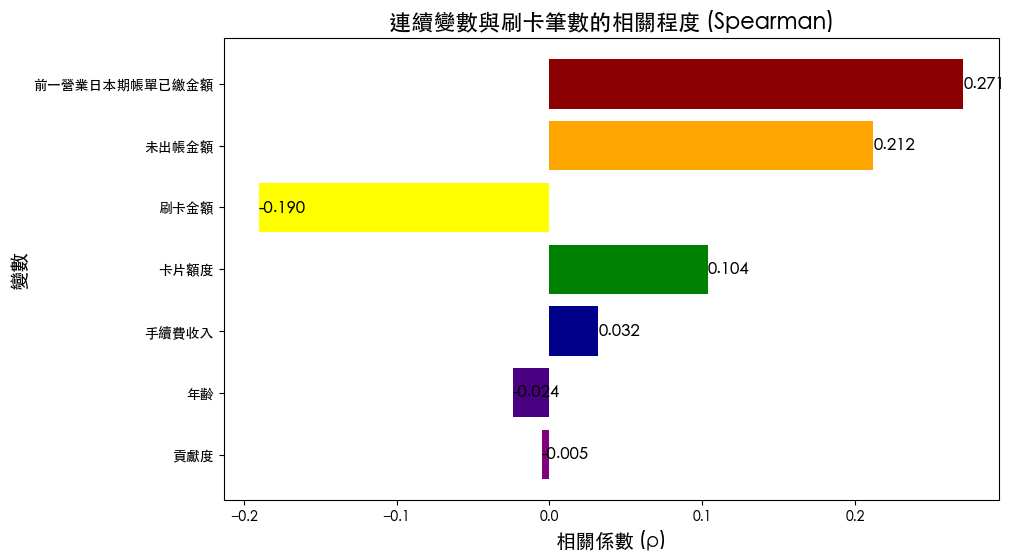

In [489]:
plt.figure(figsize=(10,6))
bars = plt.barh(res_finaldatav3["變數"], res_finaldatav3["相關係數"], color = ['darkred','orange','yellow','green','darkblue','indigo','purple'])

# 加上數字標註
for bar in bars:
    plt.text(bar.get_width(), 
             bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.3f}",
             va='center', ha='left', fontsize=12)

plt.xlabel("相關係數 (ρ)", fontsize=14)
plt.ylabel("變數", fontsize=14)
plt.title("連續變數與刷卡筆數的相關程度 (Spearman)", fontsize=16, fontweight="bold")
plt.gca().invert_yaxis()  # 讓最大值排最上面
plt.savefig('連續變數與刷卡筆數_Spearman相關係數.png',bbox_inches= 'tight')
plt.show()


### <font color = 'skyblue'>**肆-2、標準化處理(針對連續變數)**</font>

In [509]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
final_datav3[['前一營業日本期帳單已繳金額', '未出帳金額', '刷卡金額','卡片額度']] = scaler.fit_transform(final_datav3[['前一營業日本期帳單已繳金額', '未出帳金額', '刷卡金額','卡片額度']])
final_datav3[['前一營業日本期帳單已繳金額', '未出帳金額', '刷卡金額','卡片額度']] 

,前一營業日本期帳單已繳金額,未出帳金額,刷卡金額,卡片額度
0,-0.240175,-0.388962,-0.089122,0.630508
1,-0.363943,0.264386,0.235012,-0.586708
2,-0.071860,-0.388962,-0.207154,-0.330452
3,0.497102,-0.273654,0.019531,0.310188
4,-0.071860,-0.388962,-0.230735,-0.330452
...,...,...,...,...
117574,-0.363943,0.120354,-0.071925,-0.330452
117575,-0.363943,0.120354,-0.219010,-0.330452
117576,-0.205988,-0.359564,-0.107752,-0.650772
117577,-0.363943,-0.172727,1.422763,-0.330452


In [1234]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   刷卡筆數   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     1034.
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        00:12:44   Log-Likelihood:            -4.7386e+05
No. Observations:              117579   AIC:                         9.479e+05
Df Residuals:                  117506   BIC:                         9.486e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                33.5737      1.13

In [1257]:
fitted.max()

64.05403084016709

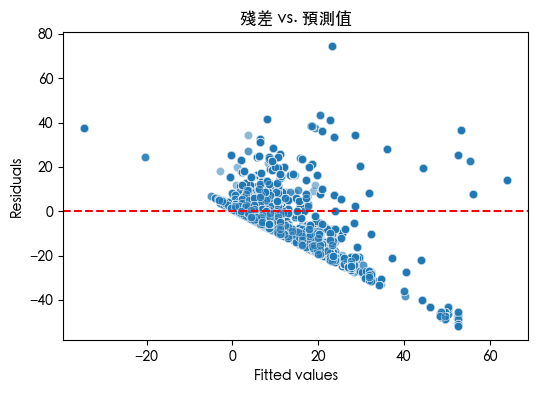

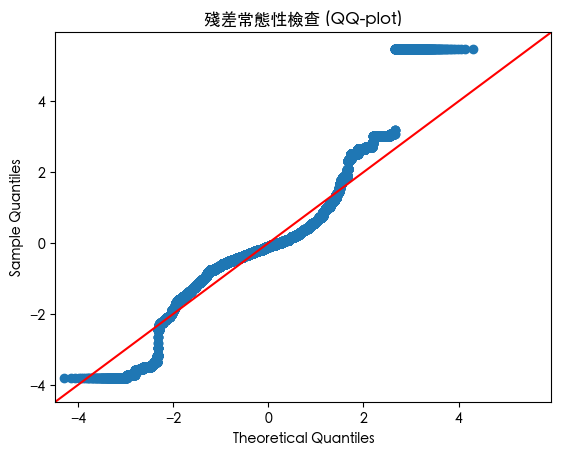

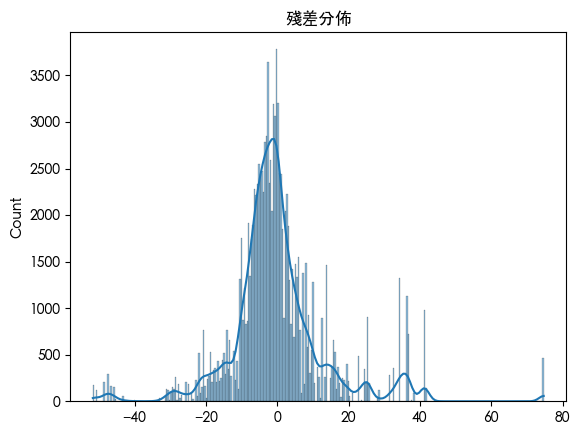

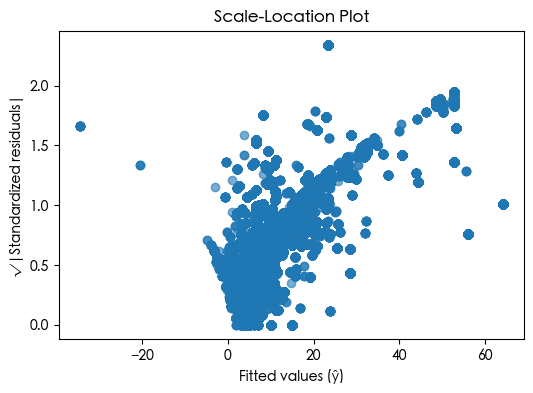

Durbin-Watson: 0.967
殘差均值: 0.000000


In [1258]:
'''
檢定殘差項是否符合(1)常態分布(2)同質變異(3)獨立性
'''

#import statsmodels.api as sm
# 假設模型是 model

resid = model.resid      #殘差
fitted = model.fittedvalues  # 係數

# (A) 殘差 vs. 預測值
plt.figure(figsize=(6,4))
sns.scatterplot(x=fitted, y=resid, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("殘差 vs. 預測值")
plt.savefig('殘差 vs. 預測值.png',format = 'png')
plt.show()

# (B) QQ-plot 檢查常態性

sm.qqplot(resid, line='45', fit=True)
plt.title("殘差常態性檢查 (QQ-plot)")
plt.savefig('殘差常態性檢查(QQ-plot).png',format = 'png')
plt.show()

# (C) 殘差直方圖
sns.histplot(resid, kde=True)
plt.title("殘差分佈")
plt.savefig('殘差分布.png',format = 'png')
plt.show()

# Scale-Location Plot (sqrt standardized residuals vs fitted)
standardized_resid = resid / np.std(resid)
plt.figure(figsize=(6,4))
plt.scatter(fitted, np.sqrt(np.abs(standardized_resid)), alpha=0.6 , cmap = '')
plt.xlabel("Fitted values (ŷ)")
plt.ylabel("√|Standardized residuals|")
plt.title("Scale-Location Plot")
plt.savefig
plt.show()

# (D) Durbin-Watson 檢定 (自相關檢查)
dw = sm.stats.stattools.durbin_watson(resid)
print(f"Durbin-Watson: {dw:.3f}")

# (E) 殘差均值檢查 (應接近 0)
print(f"殘差均值: {np.mean(resid):.6f}")

### <font color = 'skyblue'>**伍-1、正則化建模(Lasso,Rideg)**</font>

In [1067]:
# from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
# y = 目標變數
y = final_datav3_2['刷卡筆數']

# X = 連續變數 + 類別變數
cont_cols = ['前一營業日本期帳單已繳金額', '未出帳金額', '刷卡金額','卡片額度']  # 連續變數
cat_cols  = ['客戶歸屬分行名稱', '消費產品地點名稱', '幣別', '年齡群組']  # 類別變數

# 類別變數 one-hot encoding
X = pd.get_dummies(final_datav3_2[cont_cols + cat_cols], drop_first = False)

# --- 標準化 (只針對連續變數) ---
scaler = StandardScaler()
X[cont_cols] = scaler.fit_transform(X[cont_cols])

# 切分訓練/測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- LassoCV ---
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

# --- RidgeCV ---
alphas = np.logspace(-3, 3, 100)
ridge = RidgeCV(alphas=alphas, cv=5).fit(X_train, y_train)

# --- ElasticNetCV ---
elastic = ElasticNetCV(
    l1_ratio=[.1, .3, .5, .7, .9, .95, 1],
    alphas=np.logspace(-3, 2, 100),
    cv=5,
    random_state=42
).fit(X_train, y_train)

# --- 建立比較表 ---
results = pd.DataFrame({
    "模型": ["Lasso", "Ridge", "ElasticNet"],
    "最佳 alpha": [lasso.alpha_, ridge.alpha_, elastic.alpha_],
    "最佳 l1_ratio": [1, 0, elastic.l1_ratio_],
    "訓練集 R²": [lasso.score(X_train, y_train),
               ridge.score(X_train, y_train),
               elastic.score(X_train, y_train)],
    # 增加調整後 Adj R²
    "訓練集 Adj R²": [(1-(1-lasso.score(X_train, y_train)))*((len(final_datav3)-1)/(len(final_datav3)-8-1)),
                   (1-(1-ridge.score(X_train, y_train)))*((len(final_datav3)-1)/(len(final_datav3)-8-1)),
                   (1-(1-elastic.score(X_train, y_train)))*((len(final_datav3)-1)/(len(final_datav3)-8-1))],
    
    "測試集 R²": [lasso.score(X_test, y_test),
              ridge.score(X_test, y_test),
              elastic.score(X_test, y_test)],
    # 增加調整後 Adj R²
    "測試集 Adj R²": [(1-(1-lasso.score(X_test, y_test)))*((len(final_datav3)-1)/(len(final_datav3)-8-1)),
                   (1-(1-ridge.score(X_test, y_test)))*((len(final_datav3)-1)/(len(final_datav3)-8-1)),
                   (1-(1-elastic.score(X_test, y_test)))*((len(final_datav3)-1)/(len(final_datav3)-8-1))]
        
})

print(results)

# --- 各模型係數 (可額外檢查特徵重要性) ---

coef_lasso = pd.Series(lasso.coef_, index=X.columns, name="Lasso")
coef_ridge = pd.Series(ridge.coef_, index=X.columns, name="Ridge")
coef_elastic = pd.Series(elastic.coef_, index=X.columns, name="ElasticNet")

intercept_ridge = pd.Series(ridge.intercept_, index = X.columns, name = 'Ridge')
coef_df = pd.concat([coef_lasso, intercept_ridge,coef_ridge, coef_elastic], axis=1)
coef_df
  # 顯示前 15 個特徵

           模型  最佳 alpha  最佳 l1_ratio    訓練集 R²  訓練集 Adj R²    測試集 R²  \
0       Lasso  0.004686          1.0  0.441437    0.441468  0.427324   
1       Ridge  1.072267          0.0  0.442380    0.442410  0.428641   
2  ElasticNet  0.001000          1.0  0.442294    0.442324  0.428514   

   測試集 Adj R²  
0    0.427354  
1    0.428670  
2    0.428543  


In [1259]:
coef_ridge

前一營業日本期帳單已繳金額    2.644095
未出帳金額           -1.671819
刷卡金額            -1.170721
卡片額度             4.402222
客戶歸屬分行名稱_三民分行   -3.561753
                   ...   
年齡群組_56-65歲      4.399276
年齡群組_66-75歲      0.197376
年齡群組_76-85歲      3.452478
年齡群組_86-95歲      5.415592
年齡群組_96歲以上       2.063758
Name: Ridge, Length: 76, dtype: float64

In [1261]:
def print_sorted_regression_equation(model, feature_names, top_n):
    intercept = model.intercept_
    coefs = model.coef_

    # 建立 (特徵, 係數, 絕對值) 資料
    coef_list = [(f, c, abs(c)) for f, c in zip(feature_names, coefs)]
    # 依絕對值由大到小排序
    coef_list.sort(key=lambda x: x[2], reverse=True)

    #如果有設定 top_n，就只保留前 N 個
    if top_n is not None:
        coef_list = coef_list[:top_n]
    # 組合方程式
    terms = [f"{c:.4f} * {f}" for f, c, _ in coef_list]
    equation = " +\n".join(terms)
    full_eq = f"Ŷ = {intercept:.4f} +\n{equation}"

    print("依絕對值排序的迴歸方程式 (前 {}個特徵： ".format(top_n if top_n else '全部'))
    print(full_eq)
    

# 使用範例：Ridge
print_sorted_regression_equation(lasso, X_train_selected.columns, 20)


依絕對值排序的迴歸方程式 (前 20個特徵： 
Ŷ = 7.0731 +
37.3390 * cat__客戶歸屬分行名稱_建國分行 +
35.2601 * cat__消費產品地點名稱_德國 +
17.4380 * cat__客戶歸屬分行名稱_未知分行 +
15.9006 * cat__客戶歸屬分行名稱_桃園分行 +
15.5759 * cat__客戶歸屬分行名稱_前金分行 +
14.3429 * cat__客戶歸屬分行名稱_小港分行 +
12.0112 * cat__客戶歸屬分行名稱_新莊分行 +
11.8473 * cat__客戶歸屬分行名稱_桂林分行 +
11.2213 * cat__客戶歸屬分行名稱_右昌分行 +
9.9418 * cat__消費產品地點名稱_愛爾蘭 +
-7.7557 * cat__幣別_USD +
-7.4977 * cat__客戶歸屬分行名稱_成大分行 +
6.9807 * cat__客戶歸屬分行名稱_橋頭科學園區分行 +
6.0373 * cat__客戶歸屬分行名稱_營業部 +
4.3906 * num__卡片額度 +
-3.4522 * cat__年齡群組_66-75歲 +
3.1452 * cat__客戶歸屬分行名稱_鼓山分行 +
-2.7920 * cat__消費產品地點名稱_台灣 +
2.6388 * num__前一營業日本期帳單已繳金額 +
2.2486 * cat__客戶歸屬分行名稱_三多分行


In [1058]:
coef_df[['Lasso','Ridge','ElasticNet']].sort_values(by='Ridge', ascending=False).reset_index()

,index,Lasso,Ridge,ElasticNet
0,消費產品地點名稱_中國,35.326389,37.044522,36.904533
1,客戶歸屬分行名稱_岡山本洲分行,37.436558,34.091118,37.762799
2,幣別_CNY,21.941525,20.030522,23.820291
3,客戶歸屬分行名稱_新竹分行,17.319445,13.919127,17.587731
4,客戶歸屬分行名稱_板橋分行,16.088217,13.486378,17.007467
...,...,...,...,...
75,消費產品地點名稱_新加坡,-7.586913,-6.884988,-6.877896
76,消費產品地點名稱_澳大利亞,-0.000000,-9.431881,-6.663169
77,客戶歸屬分行名稱_左營分行,-7.673204,-11.534769,-7.780643
78,消費產品地點名稱_斯里蘭卡,-0.000000,-12.102294,-9.111820


In [1066]:
# 針對 Lasso 和 Ridge 的係數排序 (取絕對值)
coef_sorted = (
    coef_df[['Lasso', 'Ridge']]
    .assign(Lasso_abs = coef_df['Lasso'].abs(),
            Ridge_abs = coef_df['Ridge'].abs())
    .sort_values(by='Ridge_abs', ascending=False).reset_index()   # 你也可以換成 'Lasso_abs'
)

# 顯示前 20 個特徵
coef_sorted.head(30)

,index,Lasso,Ridge,Lasso_abs,Ridge_abs
0,消費產品地點名稱_中國,35.326389,37.044522,35.326389,37.044522
1,客戶歸屬分行名稱_岡山本洲分行,37.436558,34.091118,37.436558,34.091118
2,消費產品地點名稱_荷蘭,-28.688299,-33.161695,28.688299,33.161695
3,幣別_CNY,21.941525,20.030522,21.941525,20.030522
4,客戶歸屬分行名稱_新竹分行,17.319445,13.919127,17.319445,13.919127
5,客戶歸屬分行名稱_板橋分行,16.088217,13.486378,16.088217,13.486378
6,客戶歸屬分行名稱_九如分行,15.715753,12.152903,15.715753,12.152903
7,消費產品地點名稱_斯里蘭卡,-0.000000,-12.102294,0.000000,12.102294
8,客戶歸屬分行名稱_左營分行,-7.673204,-11.534769,7.673204,11.534769
9,消費產品地點名稱_伊朗,9.857677,11.219484,9.857677,11.219484


In [1176]:
# print("Lasso 特徵數:", len(selected_features))
# print("X_train_selected columns:", X_train_selected.columns[:10])  # 前 10 個
# print("Lasso coef 數:", len(lasso.coef_))
print("係數數量:", len(lasso.coef_))
print("欄位數:", X_train.shape[1])
len(lasso.coef_)
#df_coef.head(10).to_excel('Lasso迴歸模型.xlsx',index = False)

係數數量: 80
欄位數: 50


80

In [1126]:

# 將模型係數轉成 DataFrame
def coef_to_df(model, feature_names):
    coef = model.coef_
    df = pd.DataFrame({
        "feature": feature_names,
        "coef": coef,
        "abs_coef": np.abs(coef)
    }).sort_values("abs_coef", ascending=False)
    return df

# 輸出回歸方程式
def print_equation(model, feature_names, top_n=None):
    intercept = model.intercept_
    df = coef_to_df(model, feature_names)  # 轉成 DataFrame

    if top_n:  # 如果有指定 top_n，就只取前幾個重要變數
        df = df.head(top_n)

    terms = [f"{row.coef:.4f} * {row.feature}" for _, row in df.iterrows()]
    equation = " +\n".join(terms)  # 換行輸出
    full_eq = f"Y^ = {intercept:.4f} +\n{equation}"

    print("回歸方程式:")
    print(full_eq)
    return full_eq  # 也可以回傳，方便後續寫入檔案


In [1131]:
coef_to_df(ridge,X_train_selected.columns)

,feature,coef,abs_coef
18,cat__客戶歸屬分行名稱_岡山本洲分行,37.238449,37.238449
47,cat__幣別_CNY,19.492941,19.492941
6,cat__客戶歸屬分行名稱_九如分行,18.919032,18.919032
23,cat__客戶歸屬分行名稱_新竹分行,16.326362,16.326362
27,cat__客戶歸屬分行名稱_板橋分行,16.015026,16.015026
42,cat__消費產品地點名稱_斯里蘭卡,-14.627448,14.627448
14,cat__客戶歸屬分行名稱_大發分行,12.551110,12.551110
26,cat__客戶歸屬分行名稱_未知分行,12.203188,12.203188
21,cat__客戶歸屬分行名稱_建國分行,11.316577,11.316577
11,cat__客戶歸屬分行名稱_台北分行,10.899613,10.899613


In [540]:
print(final_datav3[cat_cols].isna().sum())
len(final_datav3)

前一營業日本期帳單已繳金額    0
未出帳金額            0
刷卡金額             0
卡片額度             0
dtype: int64


117579

In [642]:
# ============處理以下顯著變數為Nan, 以便後續做 共線性鹼澄 (VIF)=============

#final_datav3['客戶歸屬分行名稱'] = final_datav3['客戶歸屬分行名稱'].fillna('未知分行')
#final_datav3['幣別'] = final_datav3['幣別'].fillna('TWD')

#  -----將低於ＫＨＤ(68次) 以後的幣別合併------

#rare_currency = (final_datav3.groupby(['幣別'])['幣別'].size().sort_values(ascending = False)< final_datav3.groupby(['幣別'])['幣別'].size().quantile(0.75)).tail(21)
#final_datav3['幣別'] = final_datav3['幣別'].replace(rare_currency.index, 'Other')
final_datav3[(final_datav3['幣別']=='Other')&(final_datav3['國內外結帳地點']=='國內')][['幣別','消費產品地點名稱','國內外結帳地點']]

,幣別,消費產品地點名稱,國內外結帳地點
12191,Other,台灣,國內
12192,Other,德國,國內


In [645]:
#final_datav3.groupby(['幣別'])['幣別'].size().quantile(0.75)
print(final_datav3.groupby(['幣別'])['幣別'].count().sort_values(ascending = False))
final_datav3.groupby(['幣別'])['幣別'].size().describe()
#final_datav3.groupby(['幣別'])['幣別'].size().describe().to_excel('currency_statis.xlsx')
#final_datav3.groupby(['幣別'])['幣別'].count().sort_values(ascending = False).to_excel('currency_data.xlsx')

幣別
TWD      114336
USD        1335
JPY         488
CNY         436
Other       412
AUD         210
EUR         150
KRW         144
HKD          68
Name: 幣別, dtype: int64


count         9.000000
mean      13064.333333
std       37978.779957
min          68.000000
25%         150.000000
50%         412.000000
75%         488.000000
max      114336.000000
Name: 幣別, dtype: float64

### <font color = 'skyblue'>**伍-2、納入OLS建模(Oringi Least Squres,Lasso,Rideg,Elastic)**</font>

In [1162]:

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# y = 目標變數
y = final_datav3_2['刷卡筆數']

# X = 連續變數 + 類別變數
cont_cols = ['前一營業日本期帳單已繳金額', '未出帳金額', '刷卡金額','卡片額度']  # 連續變數
cat_cols  = ['客戶歸屬分行名稱', '消費產品地點名稱', '幣別', '年齡群組']  # 類別變數

# 類別變數 one-hot encoding
X = pd.get_dummies(final_datav3_2[cont_cols + cat_cols], drop_first=True)

# --- 標準化 (只針對連續變數) ---
scaler = StandardScaler()
X[cont_cols] = scaler.fit_transform(X[cont_cols])

# 切分訓練/測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== OLS =====
ols = LinearRegression().fit(X_train, y_train)
ols_score = ols.score(X_test, y_test)
ols_coef = pd.Series(ols.coef_, index=X.columns)

# --- LassoCV ---
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

# --- RidgeCV ---
alphas = np.logspace(-3, 3, 100)
ridge = RidgeCV(alphas=alphas, cv=5).fit(X_train, y_train)

# --- ElasticNetCV ---
elastic = ElasticNetCV(
    l1_ratio = [.1, .3, .5, .7, .9, .95, 1],
    alphas = np.logspace(-3, 2, 100),
    cv = 5,
    random_state=42
).fit(X_train, y_train)

# --- 建立比較表 ---
results = pd.DataFrame({
    "模型": ["Linear","Lasso", "Ridge", "ElasticNet"],
    "最佳 alpha": [None,lasso.alpha_, ridge.alpha_, elastic.alpha_],
    "最佳 l1_ratio": [None,1, 0, elastic.l1_ratio_],
    "訓練集 R²": [ols.score(X_train, y_train),
               lasso.score(X_train, y_train),
               ridge.score(X_train, y_train),
               elastic.score(X_train, y_train)],
    # 增加調整後 Adj R²
    "訓練集 Adj R²": [(1-(1-ols.score(X_train, y_train)))*((len(final_datav3)-1)/(len(final_datav3)-8-1)),
                    (1-(1-lasso.score(X_train, y_train)))*((len(final_datav3)-1)/(len(final_datav3)-8-1)),
                   (1-(1-ridge.score(X_train, y_train)))*((len(final_datav3)-1)/(len(final_datav3)-8-1)),
                   (1-(1-elastic.score(X_train, y_train)))*((len(final_datav3)-1)/(len(final_datav3)-8-1))],
    
    "測試集 R²": [ols.score(X_test, y_test),
                lasso.score(X_test, y_test),
              ridge.score(X_test, y_test),
              elastic.score(X_test, y_test)],
    # 增加調整後 Adj R²
    "測試集 Adj R²": [(1-(1-ols.score(X_test, y_test)))*((len(final_datav3)-1)/(len(final_datav3)-8-1)),
                    (1-(1-lasso.score(X_test, y_test)))*((len(final_datav3)-1)/(len(final_datav3)-8-1)),
                   (1-(1-ridge.score(X_test, y_test)))*((len(final_datav3)-1)/(len(final_datav3)-8-1)),
                   (1-(1-elastic.score(X_test, y_test)))*((len(final_datav3)-1)/(len(final_datav3)-8-1))]
})

print(results)

# --- 各模型係數 (可額外檢查特徵重要性) ---
coef_ols = pd.Series(ols.coef_, index = X.columns, name = "Linear")
coef_lasso = pd.Series(lasso.coef_, index=X.columns, name="Lasso")
coef_ridge = pd.Series(ridge.coef_, index=X.columns, name="Ridge")
coef_elastic = pd.Series(elastic.coef_, index=X.columns, name="ElasticNet")

coef_df = pd.concat([coef_ols, coef_lasso, coef_ridge, coef_elastic], axis=1)
coef_df.head(15)  # 顯示前 15 個特徵

           模型  最佳 alpha  最佳 l1_ratio    訓練集 R²  訓練集 Adj R²    測試集 R²  \
0      Linear       NaN          NaN  0.442284    0.442314  0.422266   
1       Lasso  0.004702          1.0  0.436000    0.436030  0.415684   
2       Ridge  0.114976          0.0  0.442283    0.442313  0.422270   
3  ElasticNet  0.001000          1.0  0.441838    0.441868  0.421964   

   測試集 Adj R²  
0    0.422295  
1    0.415713  
2    0.422299  
3    0.421993  


,Linear,Lasso,Ridge,ElasticNet
前一營業日本期帳單已繳金額,2.644706,2.621702,2.644095,2.631536
未出帳金額,-1.672217,-1.616947,-1.671819,-1.661149
刷卡金額,-1.170090,-1.212332,-1.170721,-1.183955
卡片額度,4.402799,4.315519,4.402222,4.385804
客戶歸屬分行名稱_三民分行,-3.560639,-2.488232,-3.561753,-3.254870
客戶歸屬分行名稱_中和分行,-5.208583,-1.183066,-5.205326,-4.260580
客戶歸屬分行名稱_中壢分行,-1.230387,-0.000000,-1.230717,-0.841476
客戶歸屬分行名稱_九如分行,13.156299,15.813252,13.174900,13.847943
客戶歸屬分行名稱_前金分行,-0.311903,0.537331,-0.312461,-0.000000
客戶歸屬分行名稱_北高雄分行,-2.574052,-1.083567,-2.570108,-2.153791


### <font color = 'jade'>**陸、共線性過高處理(合併刷卡筆數之分行，僅取高於0.5百分位數資料)**</font>

In [675]:
#敘述性統計檢視各項數據
print(final_datav3.groupby(['客戶歸屬分行名稱'])['客戶歸屬分行名稱'].size().describe(),'\n')
print(final_datav3['客戶歸屬分行名稱'].value_counts()) #print(final_datav3.groupby(['客戶歸屬分行名稱'])['客戶歸屬分行名稱'].size().sort_values(ascending = False))

count       37.000000
mean      3177.810811
std       3186.064194
min        182.000000
25%       1200.000000
50%       2480.000000
75%       4405.000000
max      18304.000000
Name: 客戶歸屬分行名稱, dtype: float64 

客戶歸屬分行名稱
營業部         18304
建國分行         7416
灣內分行         6939
三多分行         6163
九如分行         5171
前金分行         5027
台南分行         4719
市府分行         4560
三民分行         4410
北高雄分行        4405
南高雄分行        4244
鼓山分行         3719
岡山本洲分行       3619
桂林分行         3467
右昌分行         3307
大發分行         3014
新竹分行         2990
鳳山分行         2624
橋頭科學園區分行     2480
小港分行         2307
左營分行         1889
草衙分行         1746
台北分行         1701
旗津簡易型分行      1571
林口分行         1519
新莊分行         1394
中壢分行         1380
屏東分行         1200
桃園分行         1147
博愛分行         1057
成大分行          806
大直分行          780
大里分行          776
板橋分行          577
台中分行          553
未知分行          416
中和分行          182
Name: count, dtype: int64


In [5]:
#final_datav3.to_excel('final_datav3_2.xlsx',index = False)
#final_datav3_2 = pd.read_excel('/Users/sky/Documents/GitHub/ML100Days/homework/final_datav3_2.xlsx')
final_datav3_2 = pd.read_excel(r'D:\數據分析科\每月分析報告\202508\final_datav3_2.xlsx')
final_datav3_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117579 entries, 0 to 117578
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   消費說明_WBBL           117577 non-null  object        
 1   消費日期_WBBL           117579 non-null  datetime64[ns]
 2   星期幾                 117579 non-null  object        
 3   消費序號                117579 non-null  int64         
 4   帳單月份_WBBL           117579 non-null  int64         
 5   信用卡號                117579 non-null  int64         
 6   客戶編號                117579 non-null  object        
 7   年齡群組                117579 non-null  object        
 8   年齡                  117579 non-null  int64         
 9   Gender              117579 non-null  object        
 10  客戶歸屬分行名稱            117579 non-null  object        
 11  認列業績分行名稱            117579 non-null  object        
 12  消費產品地點名稱            117579 non-null  object        
 13  國內外結帳地點             117579 no

訓練集資料: 88184
驗證集資料: 17637
測試集資料: 11758


In [4]:
'''
============================================================================================================================================

-----------       因為共線性過大(>10)且多數為南部分行(25家), 故以敘述性統計出發，僅留下超過median的分行樣本數，其餘分類成 其它/未知分行     ----------

============================================================================================================================================
'''

def group_branches(df, col_name="客戶歸屬分行名稱"):
    """
    根據分行樣本數的 median 進行分組：
    - 保留 >= median 的分行，單獨保留
    - 其餘分行 (含 NaN) 合併為 '其他/未知分行'
    
    df: DataFrame
    col_name: 欄位名稱，預設 '客戶歸屬分行名稱'
    """
    
    # 計算分行樣本數
    branch_counts = df[col_name].value_counts()
    median_val = branch_counts.median()
    
    # 找出大分行
    big_branches = branch_counts[branch_counts >= median_val].index
    
    # 重新標記
    df[col_name + "_分組"] = df[col_name].apply(
        lambda x: x if x in big_branches else "其他/未知分行"
    )
    
    print(f"Median 樣本數 = {median_val:,.0f}",'\n')
    print(f"保留的大分行數量: {len(big_branches)}",'\n')
    #print(f"其他分行合併為: '其他/未知分行'")
    
    return df, big_branches


In [5]:
print(X.columns)
X.head()

NameError: name 'X' is not defined

In [6]:
print(group_branches(final_datav3_2))

Median 樣本數 = 2,480 

保留的大分行數量: 19 

(                     消費說明_WBBL  消費日期_WBBL  星期幾  消費序號  帳單月份_WBBL  \
0                          NaN 2025-04-30  星期三    14     202505   
1                          NaN 2025-05-06  星期二    23     202505   
2        2CO.COM*CYBERLINK.COM 2024-07-01  星期一     9     202407   
3       2CO.COM!CYBERLINK CORP 2024-11-10  星期日     8     202411   
4                      連加＊今天吃麵 2024-07-04  星期四    10     202407   
...                        ...        ...  ...   ...        ...   
117574            觀昇有線電視股份有限公司 2025-01-28  星期二     7     202502   
117575            觀昇有線電視股份有限公司 2025-01-28  星期二     8     202502   
117576                  觀音山加油站 2024-07-17  星期三    10     202407   
117577            觀霧休閒山莊股份有限公司 2025-01-25  星期六    10     202502   
117578            觀霧休閒山莊股份有限公司 2025-01-27  星期一    11     202502   

                    信用卡號           客戶編號    年齡群組  年齡 Gender  ...   幣別 刷卡筆數  \
0       5239800001840120  E123418890-00  36-45歲  40      M  ...  TWD    1   
1   

In [7]:
def plot_branch_distribution(df, col_name = "客戶歸屬分行名稱"):
    """
    繪製分行樣本數分布，並標記 median 門檻
    """
    
    # 計算樣本數
    branch_counts = df[col_name].value_counts()
    median_val = branch_counts.median()
    
    # 排序
    branch_counts = branch_counts.sort_values(ascending=False)
    
    # 繪圖
    plt.figure(figsize=(14,6))
    bx = sns.barplot(data  = branch_counts, color="steelblue")
    plt.axhline(median_val, color="white", linestyle="--", label = f"Median = {median_val:,.0f}")

    # 加上數字標註
    for p in bx.patches:                      #每個長條物件
        bx.annotate(                          #把數字放在長條頂端，旋轉 90° 避免文字重疊
            #f'{int(p.get_height()):,.of}'),  # 標記數字
            f'{int(p.get_height()):,.0f}',   
            (p.get_x() + p.get_width()/2. , p.get_height()),  # 位置：長條頂端       長條左邊界 : p.get_x()/ 長條右邊界:p.get_width()
            ha='center', va='top', fontsize=10, color="black",fontweight = 'heavy')
    
    # 修改 Xtick label 顏色 
    biggermedian_brch = {'營業部','建國分行','灣內分行','三多分行','九如分行','前金分行','台南分行','市府分行','三民分行','北高雄分行','南高雄分行',\
                         '鼓山分行','岡山本洲分行','桂林分行','右昌分行','大發分行','新竹分行','鳳山分行','橋頭科學園區分行'}
    for label in bx.get_xticklabels():
        if label.get_text() in biggermedian_brch:
            label.set_color('indigo')  # 指定文字紅色
        else:
            label.set_color('black')  # 其他保持黑色（可省略）
    
    plt.title("各分行樣本數分布", fontsize=14)
    plt.ylabel("樣本數", fontsize=12)
    plt.xlabel("分行名稱", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    
    # x, y 軸刻度標籤朝內
    bx.tick_params(axis = 'x', direction = 'out')
    bx.tick_params(axis = 'y', direction = 'in')
    plt.legend()
    plt.tight_layout()
    #plt.savefig('各分行樣本數.png',format = 'png')
    plt.show()


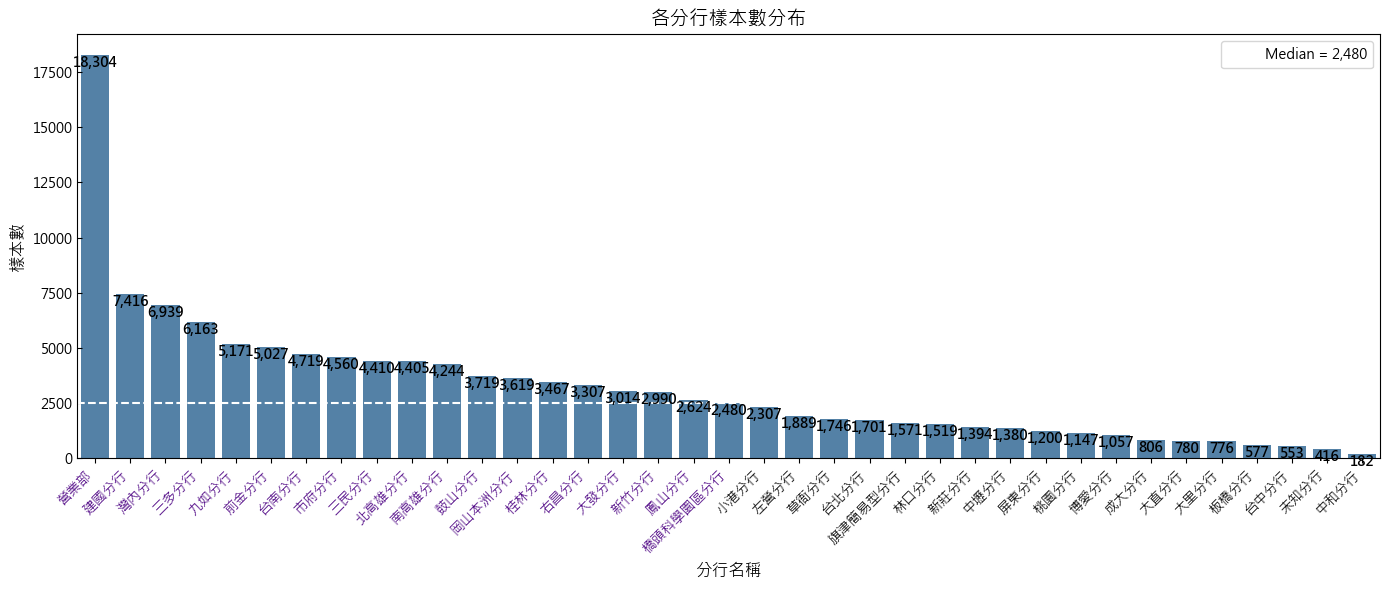

In [8]:
plot_branch_distribution(final_datav3_2)

## <font color = 'jade'>**柒、另外使用Scikit-Learn套件 處理共線性**</font>

#### 使用 Scikit-Learn 預測器的標準步驟

1. 準備欲訓練預測的特徵矩陣 $X$  與目標陣列 $y$
2. 切割訓練與驗證資料。
3. 建立預測器類別的物件。
4. 將訓練特徵矩陣 $X^{train}$ 與目標陣列 $y^{train}$ 輸入 `predictor.fit()`
5. 將驗證特徵矩陣 $X^{valid}$ 輸入 `predictor.predict()` 獲得 $\hat{y}^{valid}$
6. 比對 $\hat{y}^{valid}$ 與 $y^{valid}$ 之間的差異。

In [15]:
# ==============================
# Step 0. 套件載入
# ==============================
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures  #PolynomialFeatures 生成一個指定次方數的特徵多項式矩陣
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer                      #處理NaN
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LassoCV, RidgeCV
import matplotlib.pyplot as plt

In [10]:
X_train_transformed
print(len(selected_features))
print(selected_features[:20])

NameError: name 'X_train_transformed' is not defined

(117579, 49)

In [12]:
''' 
====================================================================

        ------   sparse matrix 與 dense matrix 比較   --------

====================================================================
'''

X_train_pred = preprocessor.transform(X_train)
print(type(X_train_pred))
print(f"sparse shape: {X_train_pred.shape}")
print(f"sparse memory: {X_train_pred.data.nbytes} bytes")

X_train_dense = X_train_pred.toarray()
print(type(X_train_dense))
print(f"dense shape: {X_train_dense.shape}")
print(f"dense memory: {X_train_dense.nbytes} bytes")

NameError: name 'preprocessor' is not defined

In [21]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler

from sklearn.compose import TransformedTargetRegressor #sklearn 會自動幫你在 fit 時轉 log，在 predict 時反轉回原始尺度
# ==============================
# Step 1. 切分訓練 / 測試資料
# ==============================

X = final_datav3_2_sorted.drop(columns=["刷卡筆數"])  # 自變數
y = np.log1p(final_datav3_2_sorted["刷卡筆數"])               # 反應變數
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# ==============================
# Step 2. 定義欄位 / ColumnTransformer
# ==============================

cont_cols =['前一營業日本期帳單已繳金額','未出帳金額','刷卡金額','卡片額度']
cat_cols = ["客戶歸屬分行名稱", "消費產品地點名稱", "幣別", "年齡群組"]

preprocessor = ColumnTransformer(
    transformers=[
         # 數值變數 → 標準化
        ("num", StandardScaler(), cont_cols),                 
        # 類別變數 → OneHot  /handle_unknown="ignore"當遇到沒見過的類別，它會自動忽略該類別，並在所有 dummy 欄位填 0
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)  
    ])


# 用完整資料 fit
preprocessor.fit(final_datav3_2)
# ===============================

# Steo 3.前處理 +Lasso 
# ===============================
X_train_pred = preprocessor.transform(X_train)
X_test_pred  = preprocessor.transform(X_test)

# step 4: 拿到特徵名稱 
features_name = preprocessor.get_feature_names_out()

# ===============================
#Step 5: 建立 LassoCV 模型
# ===============================
lasso = LassoCV(cv=5, random_state=42, max_iter=5000)
lasso.fit(X_train_pred, y_train)


# ====================================================================
# 產生轉換後的訓練資料（和 lasso.fit 時一致為80個欄位）,因為沒有設定drop =False 
# ====================================================================
X_train_transformed = pd.DataFrame(
    preprocessor.transform(X_train).toarray(),
    columns=features_name
)

# 因為 y取 log 故須有同樣的特徵長度，X_train 和 X_test 的欄位順序一樣，缺的補 0，多的丟掉
X_test_transformed = pd.DataFrame(
    preprocessor.transform(X_test).toarray(),
    columns=features_name
).reindex(columns=X_train_transformed.columns, fill_value=0)




#pipeline 用法
lasso = Pipeline(steps= [("preprocessor",preprocessor),
                         ("model",LassoCV(cv=5, random_state=42, max_iter=5000))])
lasso.fit(X_train,y_train)


# ===============================
# step 6: 取得 Lasso 篩選出的特徵
# ===============================

lasso_model = lasso.named_steps['model']
lasso_features = lasso.named_steps['preprocessor']

selected_features = [f for f, c in zip(features_name,lasso_model.coef_) if c!= 0]
print(len(selected_features))
selected_features[:20]

n = len(final_datav3_2)        # 樣本數
p = X_train_selected.shape[1]  # 使用的特徵數
# ===============================
# step 7: Lasso評估
# ===============================

print("Lasso最佳 alpha:", lasso.alpha_)
print("訓練集 R²", lasso.score(X_train_pred, y_train))
print("測試集 R²:", lasso.score(X_test_pred, y_test))
# 增加調整後 Adj R²
print("訓練集 Adj R²",(1-(1-lasso.score(X_train_pred, y_train)))*((n-1)/(n-p-1)))
print("測試集 Adj R²",(1-(1-lasso.score(X_test_pred, y_test)))*((n-1)/(n-p-1)))
                   
# ===============================
# step 8: 前處理 + Ridge
# ===============================
X_train_selected = pd.DataFrame(X_train_pred.toarray(), columns = features_name)[selected_features]
X_test_selected = pd.DataFrame(X_test_pred.toarray(), columns = features_name)[selected_features]

# 套用 lasso剩下的特徵，長度才會一致性
X_train_selected= X_train_selected[selected_features]
X_test_selected = X_test_selected[selected_features]

#Step 9: 建立 RidgeCV 模型
ridge = RidgeCV(alphas = np.logspace(-3, 3, 100),cv = 5)#np.logspace(start:代表從 10^(-3) = 開始, stop:代表從 10^(-3) = 結束, num = 在這個範圍生成 100 個等比數列的數字)
ridge.fit(X_train_selected,y_train)

# ===============================
# step 10: Ridge評估
# ===============================

print("Ridge最佳 alpha:", ridge.alpha_)
print("訓練集 R²", ridge.score(X_train_selected, y_train))
print("測試集 R²:", ridge.score(X_test_selected, y_test))
# 增加調整後 Adj R²
print("訓練集 Adj R²",(1-(1-ridge.score(X_train_selected, y_train)))*((n-1)/(n-p-1)))
print("測試集 Adj R²",(1-(1-ridge.score(X_test_selected, y_test)))*((n-1)/(n-p-1)))

65


NameError: name 'X_train_selected' is not defined

In [1266]:
X_train_selected.shape

(94063, 59)

In [1017]:
np.logspace(-3, 3, 5)

array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03])

Ŷ = 1.9433 +
1.7102 * 消費產品地點名稱_中國 +
-1.4209 * 消費產品地點名稱_荷蘭 +
1.3402 * 客戶歸屬分行名稱_未知分行 +
1.2488 * 幣別_CNY +
1.2012 * 客戶歸屬分行名稱_板橋分行 +
1.0409 * 客戶歸屬分行名稱_岡山本洲分行 +
0.9355 * 客戶歸屬分行名稱_台北分行 +
0.7133 * 客戶歸屬分行名稱_建國分行 +
0.6577 * 幣別_EUR +
0.6113 * 客戶歸屬分行名稱_新竹分行 +
0.5732 * 消費產品地點名稱_伊朗 +
-0.5493 * 客戶歸屬分行名稱_大直分行 +
0.5304 * 消費產品地點名稱_英國 +
-0.5267 * 消費產品地點名稱_愛爾蘭 +
0.4634 * 客戶歸屬分行名稱_九如分行


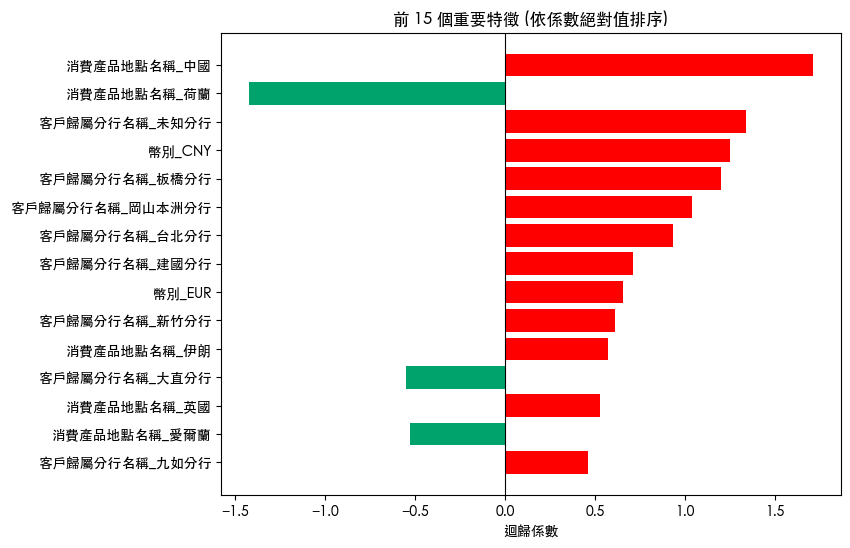

In [1419]:
'''
模型輸出至表格且繪圖 (Lasso)
'''

def coef_to_df(model, X):
    """把模型係數轉成 DataFrame，保證特徵數和係數數一致"""
    features = X.columns
    
    
    if len(features) != len(model.coef_):
        raise ValueError(f"特徵數 {len(features)} 和 係數數 {len(model.coef_)} 不一致，請確認前處理方式一致！")

    # 去掉 ColumnTransformer 加上的前綴
    clean_features = [f.replace("num__", "").replace("cat__", "") for f in features]
    
    df_coef = pd.DataFrame({
        "feature": clean_features,
        "coef": model.coef_
    })
    df_coef["abs_coef"] = df_coef["coef"].abs()
    df_coef = df_coef.sort_values("abs_coef", ascending=False).reset_index(drop=True)
    return df_coef

def print_equation(model, X, top_n=None):
    """輸出回歸方程式"""
    intercept = model.intercept_
    df_coef = coef_to_df(model, X)
    if top_n:
        df_coef = df_coef.head(top_n)

    terms = [f"{row.coef:.4f} * {row.feature}" for _, row in df_coef.iterrows()]
    equation = " +\n".join(terms)
    full_eq = f"Ŷ = {intercept:.4f} +\n{equation}"
    print(full_eq)
    return full_eq

def plot_top_features(model, X, top_n):
    """繪製前 N 個重要特徵的條狀圖"""
    df_coef = coef_to_df(model, X).head(top_n)
    plt.figure(figsize=(8, 6))

    #判斷係數顏色
    colors  = df_coef['coef'].apply(lambda x:'red' if x>0 else '#00A36C')
    plt.barh(df_coef["feature"], df_coef["coef"],color = colors)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.title(f"前 {top_n} 個重要特徵 (依係數絕對值排序)")
    plt.xlabel("迴歸係數")
    plt.gca().invert_yaxis()
    plt.savefig('lasso.png',format = 'png',bbox_inches = 'tight')
    plt.show()

# ✅ 使用方式
df_coef = coef_to_df(ridge, X_train_selected)  # 直接用 X_train_transformed

# 輸出完整回歸方程式（前 20 個）
print_equation(ridge, X_train_selected, top_n=15)

# 畫圖（前 20 個重要特徵）
plot_top_features(ridge, X_train_selected, top_n=15)


In [1435]:
from sklearn.metrics import mean_squared_error

# ✅ 測試時也要套用相同的特徵子集
X_test_selected = pd.DataFrame(
    X_test_transformed, 
    columns=features_name
)[X_train_selected.columns]  # 對齊欄位

y_pred = np.expm1(ridge.predict(X_test_selected))  # 把 log 預測值還原
mse = mean_squared_error(y_test, y_pred)
print(mse)

np.var(y, ddof=1)  

85.28956273591272


0.9811006020767723

In [1262]:
df_coef

,feature,coef,abs_coef
0,客戶歸屬分行名稱_岡山本洲分行,37.339015,37.339015
1,消費產品地點名稱_中國,35.260060,35.260060
2,消費產品地點名稱_荷蘭,-29.984495,29.984495
3,幣別_CNY,21.463679,21.463679
4,客戶歸屬分行名稱_新竹分行,17.438047,17.438047
...,...,...,...
75,消費產品地點名稱_塞普路斯,-0.000000,0.000000
76,消費產品地點名稱_加拿大,0.000000,0.000000
77,消費產品地點名稱_克羅埃西亞,-0.000000,0.000000
78,客戶歸屬分行名稱_大里分行,-0.000000,0.000000


In [1327]:
def plot_top_features(model, X, top_n):
    """繪製前 N 個重要特徵的條狀圖"""
    df_coef = coef_to_df(model, X).head(top_n)
    plt.figure(figsize=(8, 6))

    #判斷係數顏色
    colors  = df_coef['coef'].apply(lambda x:'red' if x>0 else '#00A36C')
    plt.barh(df_coef["feature"], df_coef["coef"],color = colors)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.title(f"前 {top_n} 個重要特徵 (依係數絕對值排序)")
    plt.xlabel("迴歸係數")
    plt.gca().invert_yaxis()
    plt.savefig('lasso_and_ridge_features.png',format = 'png',bbox_inches = 'tight')
    plt.show()



def compare_models(lasso, ridge, X_train_transformed, X_train_selected, top_n=15):
    """
    同時輸出 Lasso 與 Ridge 的係數 & 方程式 & Top 特徵
    """
    results = {}

    # --- Lasso (全特徵) ---
    df_lasso = coef_to_df(lasso, X_train_transformed)
    eq_lasso = print_equation(lasso, X_train_transformed, top_n=top_n)
    print("\n📌 Lasso Top Features")
    plot_top_features(lasso, X_train_transformed, top_n=top_n)

    results["Lasso"] = {"coef": df_lasso, "equation": eq_lasso}

    # --- Ridge (Lasso 篩選後的特徵) ---
    df_ridge = coef_to_df(ridge, X_train_selected)
    eq_ridge = print_equation(ridge, X_train_selected, top_n=top_n)
    print("\n📌 Ridge Top Features")
    plot_top_features(ridge, X_train_selected, top_n=top_n)

    results["Ridge"] = {"coef": df_ridge, "equation": eq_ridge}
    
    return results


Ŷ = 7.0731 +
37.3390 * 客戶歸屬分行名稱_岡山本洲分行 +
35.2601 * 消費產品地點名稱_中國 +
-29.9845 * 消費產品地點名稱_荷蘭 +
21.4637 * 幣別_CNY +
17.4380 * 客戶歸屬分行名稱_新竹分行 +
15.9006 * 客戶歸屬分行名稱_板橋分行 +
15.5759 * 客戶歸屬分行名稱_九如分行 +
14.3429 * 客戶歸屬分行名稱_大發分行 +
12.0112 * 客戶歸屬分行名稱_建國分行 +
11.8473 * 客戶歸屬分行名稱_未知分行 +
11.2213 * 客戶歸屬分行名稱_台北分行 +
9.9418 * 消費產品地點名稱_伊朗 +
7.9548 * 幣別_EUR +
-7.7557 * 消費產品地點名稱_新加坡 +
-7.4977 * 客戶歸屬分行名稱_左營分行

📌 Lasso Top Features


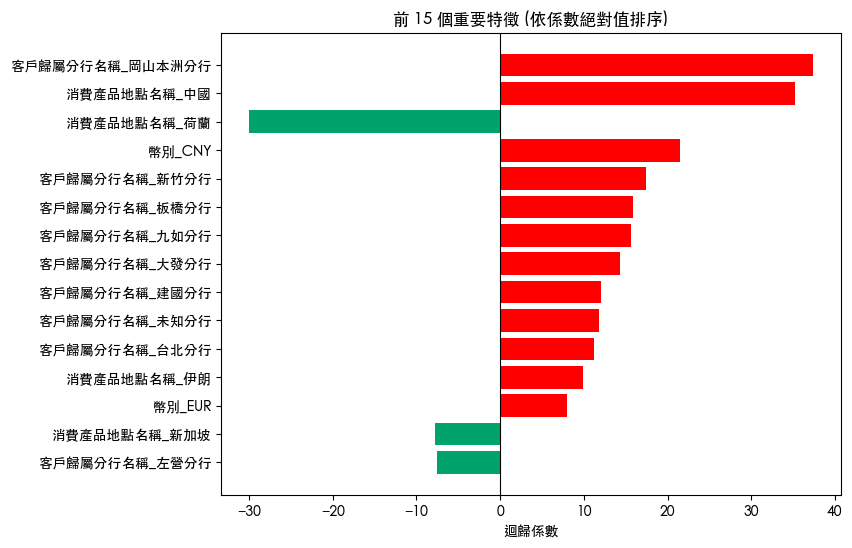

Ŷ = 5.2569 +
37.8387 * 客戶歸屬分行名稱_岡山本洲分行 +
37.3943 * 消費產品地點名稱_中國 +
-34.3741 * 消費產品地點名稱_荷蘭 +
22.8400 * 幣別_CNY +
17.8712 * 客戶歸屬分行名稱_新竹分行 +
17.1363 * 客戶歸屬分行名稱_板橋分行 +
15.8386 * 客戶歸屬分行名稱_九如分行 +
14.8870 * 客戶歸屬分行名稱_大發分行 +
13.4786 * 客戶歸屬分行名稱_未知分行 +
12.3785 * 客戶歸屬分行名稱_建國分行 +
11.8396 * 客戶歸屬分行名稱_台北分行 +
11.6761 * 消費產品地點名稱_伊朗 +
11.4959 * 幣別_EUR +
10.1190 * 消費產品地點名稱_英國 +
7.6272 * 客戶歸屬分行名稱_林口分行

📌 Ridge Top Features


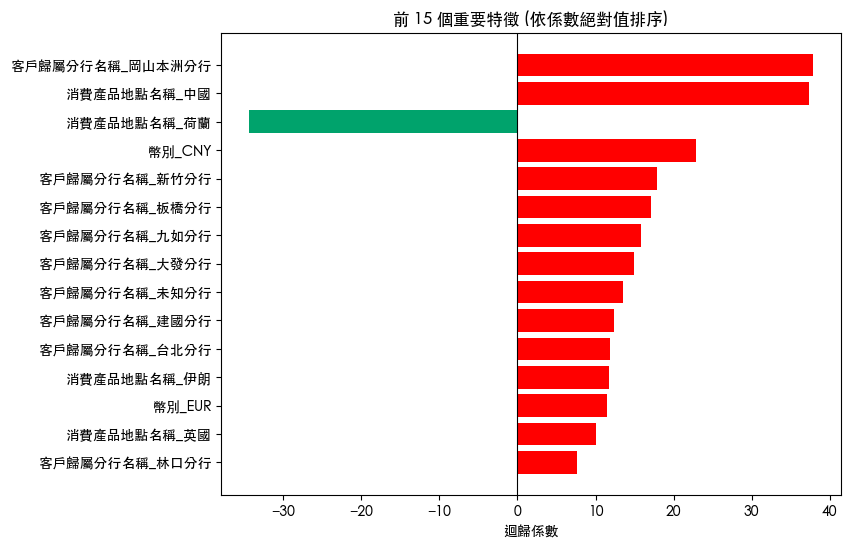

{'Lasso': {'coef':             feature       coef   abs_coef
  0   客戶歸屬分行名稱_岡山本洲分行  37.339015  37.339015
  1       消費產品地點名稱_中國  35.260060  35.260060
  2       消費產品地點名稱_荷蘭 -29.984495  29.984495
  3            幣別_CNY  21.463679  21.463679
  4     客戶歸屬分行名稱_新竹分行  17.438047  17.438047
  ..              ...        ...        ...
  75    消費產品地點名稱_塞普路斯  -0.000000   0.000000
  76     消費產品地點名稱_加拿大   0.000000   0.000000
  77   消費產品地點名稱_克羅埃西亞  -0.000000   0.000000
  78    客戶歸屬分行名稱_大里分行  -0.000000   0.000000
  79       年齡群組_96歲以上  -0.000000   0.000000
  
  [80 rows x 3 columns],
  'equation': 'Ŷ = 7.0731 +\n37.3390 * 客戶歸屬分行名稱_岡山本洲分行 +\n35.2601 * 消費產品地點名稱_中國 +\n-29.9845 * 消費產品地點名稱_荷蘭 +\n21.4637 * 幣別_CNY +\n17.4380 * 客戶歸屬分行名稱_新竹分行 +\n15.9006 * 客戶歸屬分行名稱_板橋分行 +\n15.5759 * 客戶歸屬分行名稱_九如分行 +\n14.3429 * 客戶歸屬分行名稱_大發分行 +\n12.0112 * 客戶歸屬分行名稱_建國分行 +\n11.8473 * 客戶歸屬分行名稱_未知分行 +\n11.2213 * 客戶歸屬分行名稱_台北分行 +\n9.9418 * 消費產品地點名稱_伊朗 +\n7.9548 * 幣別_EUR +\n-7.7557 * 消費產品地點名稱_新加坡 +\n-7.4977 * 客戶歸屬分行名稱_左營分行'},
 'Ridge': {'c

In [1328]:
compare_models(lasso, ridge,X_train_transformed, X_train_selected)

In [4]:
def compare_top_features_side_by_side(lasso, ridge, X_lasso, X_ridge, top_n=15):
    # 取前 N 特徵
    df_lasso = coef_to_df(lasso, X_lasso).sort_values("abs_coef",ascending=False).head(top_n)
    df_ridge = coef_to_df(ridge, X_ridge).sort_values('abs_coef',ascending = False).head(top_n)

     # 為了 barh 從上到下畫，把順序反轉
    df_lasso = df_lasso.iloc[::-1]
    df_ridge = df_ridge.iloc[::-1]

    # 找出差異特徵
    diff_features = set(df_lasso["feature"]) ^ set(df_ridge["feature"])

    fig, axes = plt.subplots(1, 2, figsize=(40, 15), sharey= False)

    for ax, df, title in zip(axes, [df_lasso, df_ridge], ["Lasso", "Ridge"]):
        if df.empty:
            ax.set_title(f"{title} 沒有可用特徵")
            continue
        plt.fontsize = 16
        colors = ['red' if c > 0 else '#00A36C' for c in df["coef"]]
        ax.barh(df["feature"], df["coef"], color=colors)

        # 把差異特徵的 y 軸文字改紅色 + 粗體
        yticks = ax.get_yticklabels()
        xticks = ax.get_xticklabels()
        
        # 先全部放大字體
        for tick in yticks:
            tick.set_fontsize(25)  
        for tick in xticks:
            tick.set_fontsize(25)  

        #不同特徵 標記紅色
        for tick, feature in zip(yticks, df["feature"]):
            if feature in diff_features:
                tick.set_color("red")
                tick.set_fontweight("bold")
                tick.set_fontsize(19)

        ax.axvline(0, color="black", linewidth=0.8)
        ax.set_title(f"{title} 前 {top_n} 特徵",fontsize = 22)
        
    plt.suptitle("Lasso vs Ridge 前 15 特徵比較", fontsize=25,fontweight = 'bold')
    plt.tight_layout()
    plt.savefig('Lasso vs Ridge 前 15 特徵比較',bbox_inches = 'tight')
    plt.show()


In [5]:
compare_top_features_side_by_side(lasso, ridge, X_train_transformed, X_train_selected)

NameError: name 'lasso' is not defined

In [1294]:
def compare_models(lasso, ridge, 
                   X_train_transformed, X_train_selected, 
                   top_n=20):
    """
    輸出 Lasso & Ridge 的回歸方程式和 Top 特徵
    """
    results = {}

    # --- Lasso (完整特徵) ---
    print("\n===== Lasso =====")
    df_lasso = coef_to_df(lasso, X_train_transformed)
    eq_lasso = print_equation(lasso, X_train_transformed, top_n=top_n)
    plot_top_features(lasso, X_train_transformed, top_n=top_n)
    results["Lasso"] = {"coef": df_lasso, "equation": eq_lasso}

    # --- Ridge (Lasso 篩後特徵) ---
    print("\n===== Ridge =====")
    df_ridge = coef_to_df(ridge, X_train_selected)
    eq_ridge = print_equation(ridge, X_train_selected, top_n=top_n)
    plot_top_features(ridge, X_train_selected, top_n=top_n)
    results["Ridge"] = {"coef": df_ridge, "equation": eq_ridge}

    return results



===== Lasso =====
Ŷ = 7.0731 +
37.3390 * 客戶歸屬分行名稱_岡山本洲分行 +
35.2601 * 消費產品地點名稱_中國 +
-29.9845 * 消費產品地點名稱_荷蘭 +
21.4637 * 幣別_CNY +
17.4380 * 客戶歸屬分行名稱_新竹分行 +
15.9006 * 客戶歸屬分行名稱_板橋分行 +
15.5759 * 客戶歸屬分行名稱_九如分行 +
14.3429 * 客戶歸屬分行名稱_大發分行 +
12.0112 * 客戶歸屬分行名稱_建國分行 +
11.8473 * 客戶歸屬分行名稱_未知分行 +
11.2213 * 客戶歸屬分行名稱_台北分行 +
9.9418 * 消費產品地點名稱_伊朗 +
7.9548 * 幣別_EUR +
-7.7557 * 消費產品地點名稱_新加坡 +
-7.4977 * 客戶歸屬分行名稱_左營分行 +
7.4664 * 消費產品地點名稱_英國 +
6.9807 * 客戶歸屬分行名稱_林口分行 +
6.0373 * 客戶歸屬分行名稱_桃園分行 +
4.3906 * 卡片額度 +
-3.9587 * 年齡群組_46-55歲


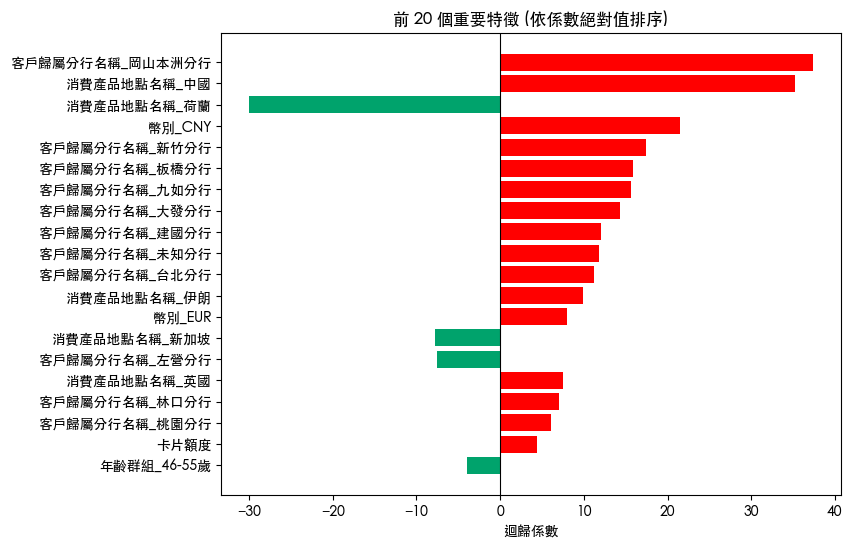


===== Ridge =====
Ŷ = 5.2569 +
37.8387 * 客戶歸屬分行名稱_岡山本洲分行 +
37.3943 * 消費產品地點名稱_中國 +
-34.3741 * 消費產品地點名稱_荷蘭 +
22.8400 * 幣別_CNY +
17.8712 * 客戶歸屬分行名稱_新竹分行 +
17.1363 * 客戶歸屬分行名稱_板橋分行 +
15.8386 * 客戶歸屬分行名稱_九如分行 +
14.8870 * 客戶歸屬分行名稱_大發分行 +
13.4786 * 客戶歸屬分行名稱_未知分行 +
12.3785 * 客戶歸屬分行名稱_建國分行 +
11.8396 * 客戶歸屬分行名稱_台北分行 +
11.6761 * 消費產品地點名稱_伊朗 +
11.4959 * 幣別_EUR +
10.1190 * 消費產品地點名稱_英國 +
7.6272 * 客戶歸屬分行名稱_林口分行 +
-7.5411 * 客戶歸屬分行名稱_左營分行 +
6.8100 * 客戶歸屬分行名稱_桃園分行 +
-6.7656 * 消費產品地點名稱_新加坡 +
4.4118 * 卡片額度 +
4.1179 * 消費產品地點名稱_德國


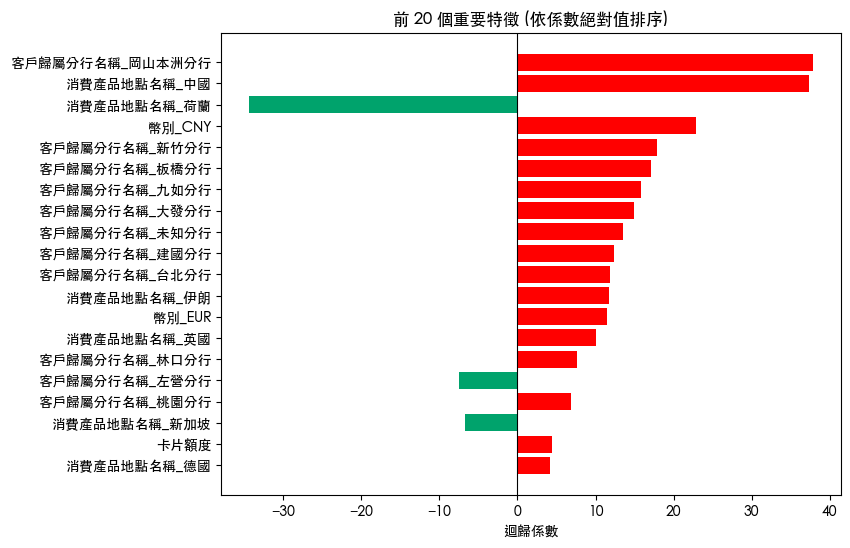

{'Lasso': {'coef':             feature       coef   abs_coef
  0   客戶歸屬分行名稱_岡山本洲分行  37.339015  37.339015
  1       消費產品地點名稱_中國  35.260060  35.260060
  2       消費產品地點名稱_荷蘭 -29.984495  29.984495
  3            幣別_CNY  21.463679  21.463679
  4     客戶歸屬分行名稱_新竹分行  17.438047  17.438047
  ..              ...        ...        ...
  75    消費產品地點名稱_塞普路斯  -0.000000   0.000000
  76     消費產品地點名稱_加拿大   0.000000   0.000000
  77   消費產品地點名稱_克羅埃西亞  -0.000000   0.000000
  78    客戶歸屬分行名稱_大里分行  -0.000000   0.000000
  79       年齡群組_96歲以上  -0.000000   0.000000
  
  [80 rows x 3 columns],
  'equation': 'Ŷ = 7.0731 +\n37.3390 * 客戶歸屬分行名稱_岡山本洲分行 +\n35.2601 * 消費產品地點名稱_中國 +\n-29.9845 * 消費產品地點名稱_荷蘭 +\n21.4637 * 幣別_CNY +\n17.4380 * 客戶歸屬分行名稱_新竹分行 +\n15.9006 * 客戶歸屬分行名稱_板橋分行 +\n15.5759 * 客戶歸屬分行名稱_九如分行 +\n14.3429 * 客戶歸屬分行名稱_大發分行 +\n12.0112 * 客戶歸屬分行名稱_建國分行 +\n11.8473 * 客戶歸屬分行名稱_未知分行 +\n11.2213 * 客戶歸屬分行名稱_台北分行 +\n9.9418 * 消費產品地點名稱_伊朗 +\n7.9548 * 幣別_EUR +\n-7.7557 * 消費產品地點名稱_新加坡 +\n-7.4977 * 客戶歸屬分行名稱_左營分行 +\n7.4664 * 消費產品

In [1295]:
compare_models(lasso, ridge, X_train_transformed, X_train_selected)

In [965]:
# 芬恩特
# 生成一個指定次方的特徵多項式矩陣
polynomial_features = PolynomialFeatures()
y_transform = polynomial_features.fit_transform(y)
y_transform[:5,:]

# 標準化變數
cont_cols =['前一營業日本期帳單已繳金額','未出帳金額','刷卡金額','卡片額度']
cat_cols = ["客戶歸屬分行名稱", "消費產品地點名稱", "幣別", "年齡群組"]
X =final_datav3_2[cont_cols  + cat_cols]
y = final_datav3_2['刷卡筆數']
standard_scaler = StandardScaler()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

# Lasso 
lasso = LassoCV(cv=5, random_state=42, max_iter=5000)
lasso.fit(X_train,y_train)
y_pred = lasso.predict(y_test)
m = y_test.size
m

ValueError: Expected 2D array, got 1D array instead:
array=[ 1  3 21 ...  5  2  2].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

WLS summary
                            WLS Regression Results                            
Dep. Variable:                   刷卡筆數   R-squared:                       0.999
Model:                            WLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.972e+07
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:39:38   Log-Likelihood:            -3.8987e+05
No. Observations:              117579   AIC:                         7.797e+05
Df Residuals:                  117574   BIC:                         7.798e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.7730      0.00

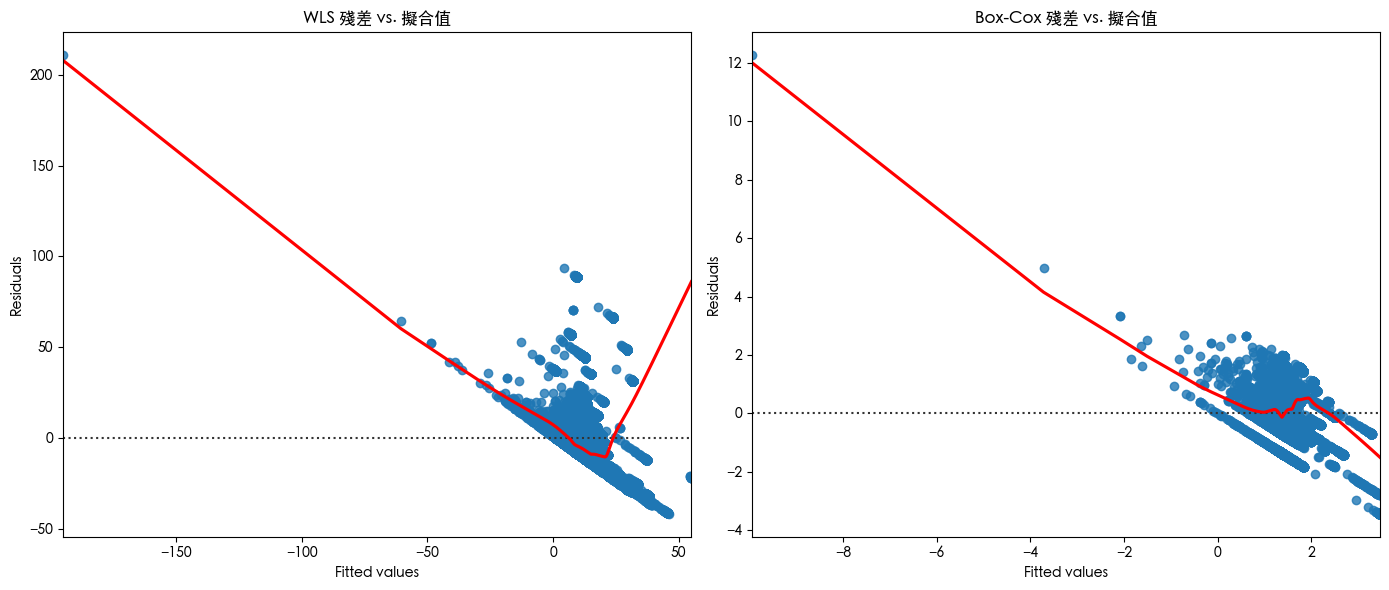

In [1436]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import WLS

from statsmodels.tools import add_constant
from statsmodels.formula.api import ols
from scipy import stats

# ==============================
# Step 1: 設定 y, X
# ==============================
# 假設你的資料
y = final_datav3_2["刷卡筆數"]
X = final_datav3_2[["刷卡金額","卡片額度","前一營業日本期帳單已繳金額","未出帳金額"]]
X = add_constant(X)

# ==============================
# Step 2: WLS 模型
# ==============================
# 先用 OLS 預估一遍，抓殘差當作權重
ols_model = sm.OLS(y, X).fit()
weights = 1 / (ols_model.resid ** 2)   # 常見設法：殘差平方的倒數

wls_model = WLS(y, X, weights=weights).fit()
print("WLS summary")
print(wls_model.summary())

# ==============================
# Step 3: Box-Cox 轉換
# ==============================
# Box-Cox 只能處理 y > 0
y_pos = y[y > 0]
X_pos = X.loc[y_pos.index]

bc_model = sm.OLS(y_pos, X_pos).fit()
y_bc, lambda_bc = stats.boxcox(y_pos)  # 找到最佳 λ
bc_model = sm.OLS(y_bc, X_pos).fit()
print(f"\nBox-Cox λ = {lambda_bc:.4f}")
print("Box-Cox summary")
print(bc_model.summary())

# ==============================
# Step 4: 殘差檢視 (比較 WLS vs Box-Cox)
# ==============================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# WLS 殘差
sns.residplot(x=wls_model.fittedvalues, y=wls_model.resid, lowess=True, ax=axes[0],
              line_kws={"color": "red"})
axes[0].set_title("WLS 殘差 vs. 擬合值")
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")

# Box-Cox 殘差
sns.residplot(x=bc_model.fittedvalues, y=bc_model.resid, lowess=True, ax=axes[1],
              line_kws={"color": "red"})
axes[1].set_title("Box-Cox 殘差 vs. 擬合值")
axes[1].set_xlabel("Fitted values")
axes[1].set_ylabel("Residuals")

plt.tight_layout()
plt.show()


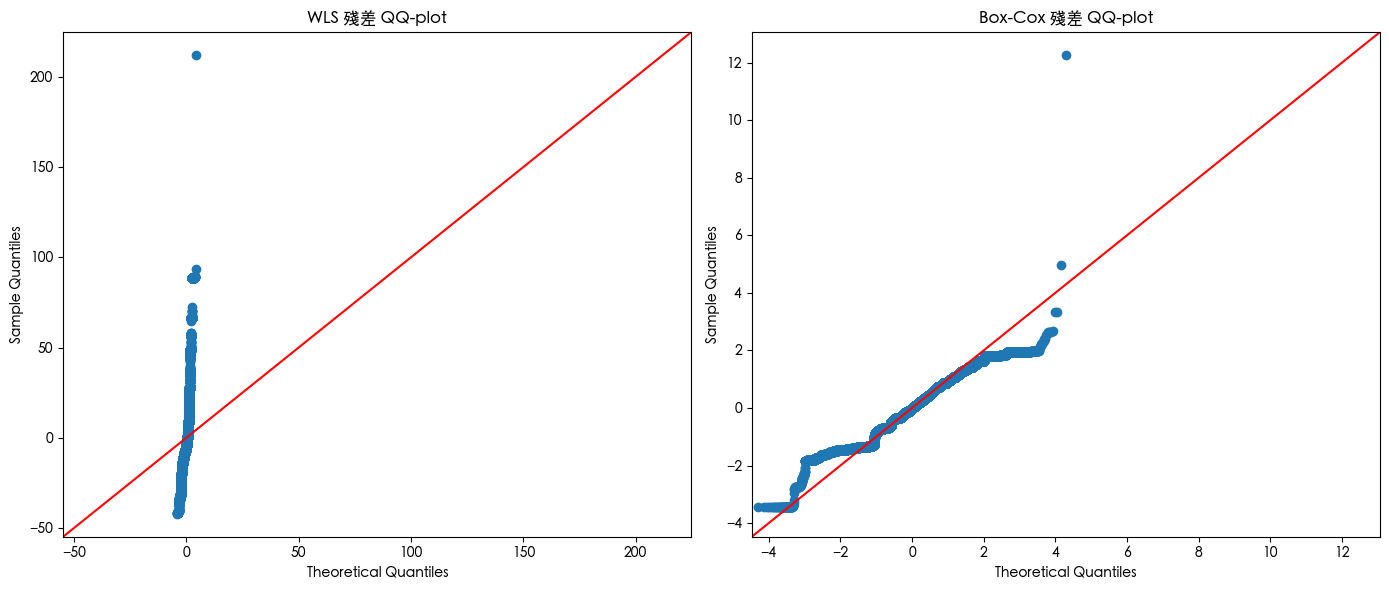

In [1437]:
import statsmodels.api as sm

# ==============================
# Step 5: QQ-plot 殘差常態性比較
# ==============================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# WLS QQ-plot
sm.qqplot(wls_model.resid, line="45", ax=axes[0])
axes[0].set_title("WLS 殘差 QQ-plot")

# Box-Cox QQ-plot
sm.qqplot(bc_model.resid, line="45", ax=axes[1])
axes[1].set_title("Box-Cox 殘差 QQ-plot")

plt.tight_layout()
plt.show()


## <font color = 'jade'>**捌、建立樹模型XGBClassifier**</font>

In [1]:
import numpy as np
import pandas as pd
import math 
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
print(os.getcwd())
from scipy import stats
from scipy.stats import chi2_contingency #卡方檢定 & Crames'v
import statistics
from IPython.display import display  #在jupyter notebook 使用預覽畫面
import sklearn
print(sklearn.__version__)
#如果只有 0.19 記得要更新至 最新版本
%matplotlib inline
# 特徵選取會用到的函數
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

import pingouin as pg  # ANOVA 單因子及變數顯著性分析 (https://pingouin-stats.org/build/html/index.html)
import researchpy      #Cramér's V（克拉梅V係數）
plt.rcParams['font.family'] = 'Microsoft JhengHei' #顯示中文字(Windows)
#plt.rcParams['font.family'] = 'Heiti TC' #顯示中文字(Mac OS)


D:\Python3.9
1.5.1


In [2]:
final_datav3_2 = pd.read_excel(r'D:\數據分析科\每月分析報告\202508\final_datav3_2.xlsx')
final_datav3_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117579 entries, 0 to 117578
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   消費說明_WBBL           117577 non-null  object        
 1   消費日期_WBBL           117579 non-null  datetime64[ns]
 2   星期幾                 117579 non-null  object        
 3   消費序號                117579 non-null  int64         
 4   帳單月份_WBBL           117579 non-null  int64         
 5   信用卡號                117579 non-null  int64         
 6   客戶編號                117579 non-null  object        
 7   年齡群組                117579 non-null  object        
 8   年齡                  117579 non-null  int64         
 9   Gender              117579 non-null  object        
 10  客戶歸屬分行名稱            117579 non-null  object        
 11  認列業績分行名稱            117579 non-null  object        
 12  消費產品地點名稱            117579 non-null  object        
 13  國內外結帳地點             117579 no

In [3]:
final_datav3_2_sorted = final_datav3_2.sort_values(by = ['客戶編號','消費日期_WBBL'],ascending = [True,True])

In [4]:
final_datav3_2_sorted['消費序號'] = final_datav3_2_sorted['消費序號'].astype(str).str.zfill(5)

In [6]:
final_datav3_2_sorted.head()

,消費說明_WBBL,消費日期_WBBL,星期幾,消費序號,帳單月份_WBBL,信用卡號,客戶編號,年齡群組,年齡,Gender,...,卡片張數,幣別,刷卡筆數,刷卡金額,外幣消費金額,手續費收入,貢獻度,卡片額度,前一營業日本期帳單已繳金額,未出帳金額
0,中油–新店北新路站（Ｄ２１５,2024-07-04,星期四,00011,202407,5239809000653110,A100612823-00,66-75歲,73,M,...,1,TWD,1,-0.058637,0,0,-541,-0.010132,-0.363943,-0.073036
1,靜思書軒新店１店,2024-07-04,星期四,00012,202407,5239809000653110,A100612823-00,66-75歲,73,M,...,1,TWD,1,0.074508,0,0,-541,-0.010132,-0.363943,-0.073036
2,得恩堂眼鏡–新店北新店,2024-07-05,星期五,00013,202407,5239809000653110,A100612823-00,66-75歲,73,M,...,1,TWD,1,0.803809,0,0,-541,-0.010132,-0.363943,-0.073036
3,APPLE.COM/BILL,2024-07-06,星期六,00014,202407,5239809000653110,A100612823-00,66-75歲,73,M,...,1,TWD,1,-0.234513,30,0,-541,-0.010132,-0.363943,-0.073036
4,中油–新店北新路站（Ｄ２１５,2024-07-23,星期二,00006,202408,5239809000653110,A100612823-00,66-75歲,73,M,...,1,TWD,1,-0.079742,0,0,-541,-0.010132,-0.363943,-0.073036


In [ ]:
sample = final_datav3_2_sorted[(final_datav3_2_sorted['客戶編號']=='Y220521208-00')]
# & (final_datav3_2_sorted['消費日期_WBBL']=='2024-07-4')

final_datav3_2_sorted[['客戶編號','帳單月份_WBBL']]

In [7]:
final_datav3_2_sorted.groupby(['客戶編號','帳單月份_WBBL'])['刷卡筆數'].count().reset_index()

,客戶編號,帳單月份_WBBL,刷卡筆數
0,A100612823-00,202407,4
1,A100612823-00,202408,5
2,A100612823-00,202409,3
3,A100612823-00,202410,5
4,A100612823-00,202411,8
...,...,...,...
14871,Y220515335-00,202504,2
14872,Y220515335-00,202505,2
14873,Y220515335-00,202506,2
14874,Y220521208-00,202506,8


In [5]:
total_row = len(final_datav3_2_sorted)

# 按比例切分
train_ratio = 0.75
valid_ratio = 0.15
test_ratio = 0.10

train_set = int(total_row * train_ratio)
valid_set = int(total_row * (train_ratio+valid_ratio))

test_set = int(total_row*test_ratio)
print(train_set)
print(valid_set)
print(test_set)
print(train_set+(valid_set-train_set+1)+test_set)

88184
105821
11757
117579


In [6]:
### 時間序列資料正確切割方式
train_data = final_datav3_2_sorted[:train_set]
valid_data = final_datav3_2_sorted[train_set:valid_set]
test_data  = final_datav3_2_sorted[valid_set:]
print('訓練集資料:',len(train_data))
print('驗證集資料:',len(valid_data))
print('測試集資料:',len(test_data))


訓練集資料: 88184
驗證集資料: 17637
測試集資料: 11758


In [7]:
X_train_data = train_data.drop(columns = '刷卡筆數')
X_valid_data = valid_data.drop(columns = '刷卡筆數')
X_test_data = test_data.drop(columns = '刷卡筆數')
y_train_data = train_data['刷卡筆數']
y_valid_data = valid_data['刷卡筆數']
y_test_data = test_data['刷卡筆數']

In [8]:

print(X_train_data.shape)
print(y_train_data.shape)
print(X_valid_data.shape)
print(y_valid_data.shape)
print(X_test_data.shape)
print(y_test_data.shape)

print('\n',X_train_data.shape[1])
print('\n',y_train_data.head())

(88184, 48)
(88184,)
(17637, 48)
(17637,)
(11758, 48)
(11758,)

 48

 0    1
1    1
2    1
3    1
4    1
Name: 刷卡筆數, dtype: int64


In [9]:
import sklearn
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,log_loss

In [19]:
#處理類別變數 LabelEncoder

from sklearn.preprocessing import LabelEncoder

X_train_encoded = X_train_data.copy()
X_valid_encoded = X_valid_data.copy()
X_test_encoded = X_test_data.copy()

# 對每個 object 欄位做編碼
object_cols = X_train_data.select_dtypes(include='object').columns

for col in object_cols:
    le = LabelEncoder()

# 合併所有可能的值
all_values = pd.concat([
X_train_data[col],
X_valid_data[col],
X_test_data[col]
]).astype(str)

le.fit(all_values)
# 轉換
X_train_encoded[col] = le.transform(X_train_data[col].astype(str))
X_valid_encoded[col] = le.transform(X_valid_data[col].astype(str))
X_test_encoded[col] = le.transform(X_test_data[col].astype(str))


print('編碼完成！')


編碼完成！


In [35]:
X_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88184 entries, 0 to 88183
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   消費說明_WBBL           88182 non-null  object        
 1   消費日期_WBBL           88184 non-null  datetime64[ns]
 2   星期幾                 88184 non-null  object        
 3   消費序號                88184 non-null  object        
 4   帳單月份_WBBL           88184 non-null  int64         
 5   信用卡號                88184 non-null  int64         
 6   客戶編號                88184 non-null  object        
 7   年齡群組                88184 non-null  object        
 8   年齡                  88184 non-null  int64         
 9   Gender              88184 non-null  object        
 10  客戶歸屬分行名稱            88184 non-null  object        
 11  認列業績分行名稱            88184 non-null  object        
 12  消費產品地點名稱            88184 non-null  object        
 13  國內外結帳地點             88184 non-null  object    

In [32]:
X_train_encoded.

,消費說明_WBBL,消費日期_WBBL,星期幾,消費序號,帳單月份_WBBL,信用卡號,客戶編號,年齡群組,年齡,Gender,...,客戶數,卡片張數,幣別,刷卡金額,外幣消費金額,手續費收入,貢獻度,卡片額度,前一營業日本期帳單已繳金額,未出帳金額
0,中油–新店北新路站（Ｄ２１５,2024-07-04,星期四,00011,202407,5239809000653110,A100612823-00,66-75歲,73,M,...,1,1,7,-0.058637,0,0,-541,-0.010132,-0.363943,-0.073036
1,靜思書軒新店１店,2024-07-04,星期四,00012,202407,5239809000653110,A100612823-00,66-75歲,73,M,...,1,1,7,0.074508,0,0,-541,-0.010132,-0.363943,-0.073036
2,得恩堂眼鏡–新店北新店,2024-07-05,星期五,00013,202407,5239809000653110,A100612823-00,66-75歲,73,M,...,1,1,7,0.803809,0,0,-541,-0.010132,-0.363943,-0.073036
3,APPLE.COM/BILL,2024-07-06,星期六,00014,202407,5239809000653110,A100612823-00,66-75歲,73,M,...,1,1,7,-0.234513,30,0,-541,-0.010132,-0.363943,-0.073036
4,中油–新店北新路站（Ｄ２１５,2024-07-23,星期二,00006,202408,5239809000653110,A100612823-00,66-75歲,73,M,...,1,1,7,-0.079742,0,0,-541,-0.010132,-0.363943,-0.073036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88179,APPLE.COM/BILL,2024-07-05,星期五,00011,202407,5239800001915100,S121528876-00,56-65歲,57,M,...,1,1,7,-0.234513,30,0,105,0.310188,-0.363943,-0.388962
88180,APPLE.COM/BILL,2024-07-19,星期五,00009,202408,5239800001915100,S121528876-00,56-65歲,57,M,...,1,1,7,-0.227999,80,0,105,0.310188,-0.363943,-0.388962
88181,APPLE.COM/BILL,2024-08-05,星期一,00010,202408,5239800001915100,S121528876-00,56-65歲,57,M,...,1,1,7,-0.234513,30,0,105,0.310188,-0.363943,-0.388962
88182,亞柏八卦寮加油站,2024-08-15,星期四,00008,202409,5239800001915100,S121528876-00,56-65歲,57,M,...,1,1,7,-0.035317,0,0,105,0.310188,-0.363943,-0.388962


In [24]:
# 轉換
for col in object_cols:
    le = LabelEncoder()

In [25]:
# 建立樹回歸模型
xgb_regressor_model = XGBRegressor(max_depth = 3,
                                   learning_rate = 0.05,    #learning_rate
                                   n_estimators = 300,
                                   subsample = 0.5,
                                   colsample_bytree = 0.5,
                                   reg_alpha = 50,
                                   reg_lambda = 0,
                                   verbose = False,   # 不須輸出資訊
                                   eval_metric = 'rmse',
                                   random_state = 42,
                                   n_jobs = -1
                                    )

In [27]:
xgb_regressor_model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.5, eta=0.05,
             eval_metric='rmse', gamma=None, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=3,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=50, reg_lambda=0, scale_pos_weight=None,
             subsample=0.5, tree_method=None, validate_parameters=None,
             verbose=False, verbosity=None)

In [38]:
!pip uninstall xgboost -y
!pip install xgboost==2.0.3

Found existing installation: xgboost 3.0.5
Uninstalling xgboost-3.0.5:
  Successfully uninstalled xgboost-3.0.5


You can safely remove it manually.


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
     - -------------------------------------- 4.7/99.8 MB 23.7 MB/s eta 0:00:05
     --- ------------------------------------ 7.6/99.8 MB 19.6 MB/s eta 0:00:05
     ---- ---------------------------------- 10.5/99.8 MB 17.2 MB/s eta 0:00:06
     ----- --------------------------------- 13.6/99.8 MB 16.4 MB/s eta 0:00:06
     ------ -------------------------------- 16.5/99.8 MB 16.0 MB/s eta 0:00:06
     ------- ------------------------------- 19.4/99.8 MB 15.7 MB/s eta 0:00:06
     -------- ------------------------------ 22.3/99.8 MB 15.3 MB/s eta 0:00:06
     --------- ----------------------------- 25.2/99.8 MB 15.3 MB/s eta 0:00:05
     ---------- ---------------------------- 28.0/99.8 MB 15.1 MB/s eta 0:00:05
     ----------- --------------------------- 30.7/99.8 MB 14.9 MB/s eta 0:00:05
     ------------- ------------------------- 33.6/99.8 MB 14.8 MB/s

In [12]:
print(xgb.__version__)
print('EarlyStopping存在',hasattr(xgb.callback,'EarlyStopping'))
print('可用的callbacks:',dir(xgb.callback))

2.0.3
EarlyStopping存在 True
可用的callbacks: ['ABC', 'Any', 'Booster', 'Callable', 'CallbackContainer', 'DMatrix', 'Dict', 'EarlyStopping', 'EvaluationMonitor', 'LearningRateScheduler', 'List', 'Optional', 'Sequence', 'TrainingCallback', 'TrainingCheckPoint', 'Tuple', 'TypeVar', 'Union', 'XGBoostError', '_ART', '_Model', '_Score', '_ScoreList', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_aggcv', '_allreduce_metric', '_parse_eval_str', 'cast', 'collections', 'collective', 'numpy', 'os', 'pickle']


In [30]:
# 模型訓練 並用驗證集監控
xgb_regressor_model.fit(X_train_encoded, y_train_data,
                        eval_set = [(X_valid_encoded,y_valid_data)],
                        #early_stopping_rounds = 50,
                        callbacks = [EarlyStopping(rounds = 50,save_best = True)],
                        verbose = True)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:消費說明_WBBL: object, 消費日期_WBBL: datetime64[ns], 星期幾: object, 消費序號: object, 客戶編號: object, 年齡群組: object, Gender: object, 客戶歸屬分行名稱: object, 認列業績分行名稱: object, 消費產品地點名稱: object, 國內外結帳地點: object, 是否為有效卡: object, 開卡狀態: object, 信用卡等級: object, 正副卡類別: object, Prod Name M: object, 信用卡類別: object, 個人評等: object, 客戶風險等級: object, 保險業務註記: object, 信用卡業務註記: object, 信託業務註記: object, 外匯業務註記: object, 存匯業務註記: object, 客戶申請個資停止蒐集、處理、利用註記: object, 所有業務無往來註記: object, 投資理財業務註記: object, 授信業務註記: object, 是否進行kyc註記: object, 行員註記: object, 薪轉戶註記: object, 黑名單註記: object, 警示戶註記: object, 財管客戶註記: object

In [17]:
import xgboost as xgb
print(xgb.__file__)
print(xgb.__version__)

C:\Users\b003087\AppData\Local\anaconda3\Lib\site-packages\xgboost\__init__.py
2.0.3


In [43]:
# ========== 步驟 1：檢查原始資料 ==========
print('===== X_train_data 原始資料型態 =====')
print(X_train_data.dtypes)
print(f'\n總共 {len(X_train_data.columns)} 個欄位')

# 找出所有 object 欄位
object_cols = X_train_data.select_dtypes(include='object').columns
print(f'\n有 {len(object_cols)} 個 object 欄位:')
print(object_cols.tolist())

# ========== 步驟 2：複製資料（重要！）==========
X_train_encoded = X_train_data.copy()
X_valid_encoded = X_valid_data.copy()
X_test_encoded = X_test_data.copy()

print('\n開始編碼...')

# ========== 步驟 3：對每個 object 欄位編碼 ==========
for i, col in enumerate(object_cols, 1):
    print(f'[{i}/{len(object_cols)}] 處理欄位: {col}')

try:
    le = LabelEncoder()

# 合併所有值
    all_values = pd.concat([
X_train_data[col],
X_valid_data[col],
X_test_data[col]
]).astype(str)

# 訓練 LabelEncoder
    le.fit(all_values)

# 轉換三個資料集
    X_train_encoded[col] = le.transform(X_train_data[col].astype(str))
    X_valid_encoded[col] = le.transform(X_valid_data[col].astype(str))
    X_test_encoded[col] = le.transform(X_test_data[col].astype(str))

    print(f' ✓ 成功編碼: {col}')

except Exception as e:
    print(f' ✗ 編碼失敗: {col}, 錯誤: {e}')

    print('\n編碼完成！')

===== X_train_data 原始資料型態 =====
消費說明_WBBL                     object
消費日期_WBBL             datetime64[ns]
星期幾                           object
消費序號                          object
帳單月份_WBBL                      int64
信用卡號                           int64
客戶編號                          object
年齡群組                          object
年齡                             int64
Gender                        object
客戶歸屬分行名稱                      object
認列業績分行名稱                      object
消費產品地點名稱                      object
國內外結帳地點                       object
是否為有效卡                        object
開卡狀態                          object
卡片狀態                           int64
信用卡等級                         object
正副卡類別                         object
Prod Name M                   object
信用卡類別                         object
個人評等                          object
客戶風險等級                        object
保險業務註記                        object
信用卡業務註記                       object
信託業務註記                        object
外匯業務註記

In [44]:

# ========== 步驟 4：檢查編碼後的資料 ==========
print('\n===== X_train_encoded 編碼後資料型態 =====')
print(X_train_encoded.dtypes)

# 檢查是否還有 object 欄位
remaining_objects = X_train_encoded.select_dtypes(include='object').columns
if len(remaining_objects) > 0:
    print(f'\n⚠️ 警告：還有 {len(remaining_objects)} 個 object 欄位:')
    print(remaining_objects.tolist())
else:
    print('\n✅ 所有 object 欄位都已編碼！')

# ========== 步驟 5：訓練模型（用編碼後的資料）==========
print('\n開始訓練模型...')

model = xgb.XGBRegressor(
max_depth=3,
learning_rate=0.05,
n_estimators=500,
random_state=42
)

# ⭐ 重點：使用 X_train_encoded（編碼後的資料）
model.fit(
X_train_encoded, y_train_data, # ← 這裡！
eval_set=[(X_valid_encoded, y_valid_data)], # ← 這裡！
callbacks=[xgb.callback.EarlyStopping(rounds=50, save_best=True)],
verbose=True
)

print('\n訓練完成！')
print(f'最佳迭代數: {model.best_iteration}')
print(f'最佳驗證分數: {model.best_score}')


===== X_train_encoded 編碼後資料型態 =====
消費說明_WBBL                     object
消費日期_WBBL             datetime64[ns]
星期幾                           object
消費序號                          object
帳單月份_WBBL                      int64
信用卡號                           int64
客戶編號                          object
年齡群組                          object
年齡                             int64
Gender                        object
客戶歸屬分行名稱                      object
認列業績分行名稱                      object
消費產品地點名稱                      object
國內外結帳地點                       object
是否為有效卡                        object
開卡狀態                          object
卡片狀態                           int64
信用卡等級                         object
正副卡類別                         object
Prod Name M                   object
信用卡類別                         object
個人評等                          object
客戶風險等級                        object
保險業務註記                        object
信用卡業務註記                       object
信託業務註記                        object
外

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:消費說明_WBBL: object, 消費日期_WBBL: datetime64[ns], 星期幾: object, 消費序號: object, 客戶編號: object, 年齡群組: object, Gender: object, 客戶歸屬分行名稱: object, 認列業績分行名稱: object, 消費產品地點名稱: object, 國內外結帳地點: object, 是否為有效卡: object, 開卡狀態: object, 信用卡等級: object, 正副卡類別: object, Prod Name M: object, 信用卡類別: object, 個人評等: object, 客戶風險等級: object, 保險業務註記: object, 信用卡業務註記: object, 信託業務註記: object, 外匯業務註記: object, 存匯業務註記: object, 客戶申請個資停止蒐集、處理、利用註記: object, 所有業務無往來註記: object, 投資理財業務註記: object, 授信業務註記: object, 是否進行kyc註記: object, 行員註記: object, 薪轉戶註記: object, 黑名單註記: object, 警示戶註記: object, 財管客戶註記: object

In [ ]:

# ========== 步驟 6：預測和評估 ==========
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_pred = model.predict(X_test_encoded) # ← 用編碼後的資料

print('\n===== 測試集表現 =====')
print(f'MSE: {mean_squared_error(y_test_data, y_pred):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_data, y_pred)):.4f}')
print(f'MAE: {mean_absolute_error(y_test_data, y_pred):.4f}')
print(f'R²: {r2_score(y_test_data, y_pred):.4f}')
